## 1. Load R packages

In [1]:
# data wrangling/exploration
library(readr)
library(tidyr)
library(GGally)
library(stringr)
library(EnvStats)
library("factoextra") # PCA
library(data.table) #makes calling grep easier %like%

# plotting
library(ggplot2)
library(viridis)
library(ggpubr)
library(ggrepel)   #for text labels on plots

#tables
library(dplyr)
library(stargazer)

#cite
library(knitr)

#modeling
library(broom)

options(jupyter.plot_mimetypes = c("text/plain","image/png"))

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [2]:
# sessionInfo()

In [3]:
#identify locations of data and figures and tables
path_f=paste(getwd(),"/Figures_and_tables/", sep="")
path_d=paste(getwd(),"/Data/", sep="")

#sizing in mm based on https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing
min_w=30
single.col_w= 90
half.col_w= 140
max_w= 190
max_h=240


## 2. Load & wrangle dataset

In [4]:
#read files
filenames <- list.files(path=path_d,pattern="*csv")

#names without extension
names <-sapply(strsplit(filenames, "\\."), `[`, 1)

# load
for(i in names){
    filepath <- file.path(path_d,paste(i,".csv",sep=""))
    assign(i, read.delim(filepath,sep = ","))
}


In [5]:
#read files
filenames <- list.files(path=path_d,pattern="*tsv")

#names without extension
names <-sapply(strsplit(filenames, "\\."), `[`, 1)

# load
for(i in names){
    filepath <- file.path(path_d,paste(i,".tsv",sep=""))
    assign(i, read.delim(filepath,sep = "\t"))
}


In [6]:

ms2_s<-ms2[,c("project","sample_date","id","dilution_factor","plaque_count", "sample_vol_uL")]
unique(ms2_s$sample_vol_uL)
names(ms2_s)<-c("project","sample_date","id","dilution_factor","count", "sample_vol_uL")
ms2_s<-ms2_s[!(ms2_s$id %in% c('B-2-R-M-T1', 'B-2-R-M-T0', 'B-2-R-M-T2', 'B-2-25-M-T1', 'B-2-25-M-T0', 'B-2-25-M-T2')),]

k12_s<-k12[,c("project","sample_date","id","dilution_factor","colony_count","sample_vol_uL")]
names(k12_s)<-c("project","sample_date","id","dilution_factor","count", "sample_vol_uL")
unique(k12_s$sample_vol_uL)

df<-rbind(k12_s, ms2_s)
df<-df[df$project=="grazing",]
head(df)

[1] 300

[1] 20

,project,sample_date,id,dilution_factor,count,sample_vol_uL
,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
72,grazing,4/19/23,B-1-F-K-T0,1000,12,20
73,grazing,4/19/23,B-1-F-K-T0,100,101,20
74,grazing,4/19/23,B-1-F-K-T0,10,TNTC,20
75,grazing,4/19/23,B-1-F-K-T0,1,TNTC,20
76,grazing,4/19/23,B-2-F-K-T0,1000,10,20
77,grazing,4/19/23,B-2-F-K-T0,100,122,20


### Field

In [7]:
field_code<-field
field[field$water=="B","water"]<- "San Gregorio State Beach"
field[field$water=="C","water"]<- "San Pedro Beach - April"
field[field$water=="D","water"]<- "San Pedro Creek"
field[field$water=="E","water"]<- "San Francisco Bay"
field[field$water=="F","water"]<- "Lake Chabot"
field[field$water=="G","water"]<- "San Pedro Beach - June"

field_n<- field_code
field_filtered<- field_n[(field_n$filtered=="R"),]
field_filtered<- field_filtered[c("water", "filtered_for_c2_mL", "filtered_for_c1_mL")]
field_w<-field
field<-gather(field_code, name, value, collection_temperature_C:turbidity)

field_m<- field[,c("water","filtered", "name","value")]


### zooplankton

In [8]:
zoo1$count<-as.character(zoo1$count)
zoo2$count<-as.character(zoo2$count)

zoo1[zoo1$count == "TNTC", "count"] <- "100000" #high number to sub later
zoo2[zoo2$count == "TNTC", "count"] <- "100000" #high number to sub later

zoo1$count<-as.numeric(zoo1$count)
zoo2$count<-as.numeric(zoo2$count)

zoo1_drop<-zoo1[,c("water", "ID", "dilution", "count", "volume_observed_mL")]
zoo2_drop<-zoo2[,c("water", "ID", "dilution", "count", "volume_observed_mL")]

zoo1_drop<-zoo1_drop[zoo1_drop$ID != "unknown",] #was not able to confidently ID these so do not count in case debris

zoo1_drop<- zoo1_drop %>% 
group_by(water, ID, dilution, volume_observed_mL) %>% 
summarize(count= as.numeric(sum(count)))

zoo<- rbind(zoo1_drop,zoo2_drop)
head(zoo)

`summarise()` has grouped output by 'water', 'ID', 'dilution'. You can override
using the `.groups` argument.


water,ID,dilution,volume_observed_mL,count
<chr>,<chr>,<int>,<int>,<dbl>
D,copepoda juvenile,0,5,1
D,diptera larvae,0,5,1
D,rotifera,0,5,3
D,worm,0,5,5
E,copepoda adult,0,5,173
E,copepoda juvenile,0,5,100000


In [9]:
zf<- field_n[(field_n$filtered=="R"),c("water", "filtered_for_zooplankton_L", "zooplankton_ethanol_mL")]
zoo<- left_join(zoo, zf)
head(zoo)

zoo=zoo[zoo$count < 100000,] #remove TNTC
zoo_t<-zoo %>% group_by(water, volume_observed_mL,filtered_for_zooplankton_L, zooplankton_ethanol_mL, dilution) %>% summarize(count =sum(count))
zoo_t$ID<-"all_identified_plankton"
zoo<-rbind(zoo, zoo_t)
unique(zoo$ID)

Joining with `by = join_by(water)`


water,ID,dilution,volume_observed_mL,count,filtered_for_zooplankton_L,zooplankton_ethanol_mL
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
D,copepoda juvenile,0,5,1,15.0,19
D,diptera larvae,0,5,1,15.0,19
D,rotifera,0,5,3,15.0,19
D,worm,0,5,5,15.0,19
E,copepoda adult,0,5,173,27.5,21
E,copepoda juvenile,0,5,100000,27.5,21


`summarise()` has grouped output by 'water', 'volume_observed_mL',
'filtered_for_zooplankton_L', 'zooplankton_ethanol_mL'. You can override using
the `.groups` argument.


[1] "copepoda juvenile"       "diptera larvae"         
 [3] "rotifera"                "worm"                   
 [5] "copepoda adult"          "cladocera"              
 [7] "appendicularia larvae"   "ciliate"                
 [9] "cirripede nauplius"      "dinoflagellate"         
[11] "diatom"                  "filimentous algae"      
[13] "dinoflagellate cyst"     "all_identified_plankton"

In [10]:
zoo$concentration_cells_per_mL<- NA
Vplate=5 #always into 5 mL tot
Vdil=1
zoo$concentration_cells_per_mL<- (zoo$count * zoo$zooplankton_ethanol_mL*(Vplate^zoo$dilution))/(zoo$volume_observed_mL*(Vdil^zoo$dilution)*zoo$filtered_for_zooplankton_L *1000)
zoo_fin<- zoo[zoo$concentration_cells_per_mL >0,]
zoo_fin<- zoo_fin[,c('water','ID', 'concentration_cells_per_mL')]
zoo_fin<- zoo_fin  %>% 
    group_by(water, ID) %>% 
    summarize(num_zooconc_reps= as.numeric(n()),
           gmean_zooconc_cells.mL = as.numeric(geoMean(concentration_cells_per_mL, na.rm = TRUE)),
           gstd_zooconc_cells.mL= as.numeric(geoSD(concentration_cells_per_mL, na.rm = TRUE)))

zoo_fin$filtered<-"R"
zoo_m<- zoo_fin
zoo_m$ID<- gsub(" ","_",zoo_m$ID)
zoo_m$description<- zoo_m$ID
zoo_m$type<-"geometric"
zoo_m<-zoo_m[,c("water", "filtered","num_zooconc_reps", "gmean_zooconc_cells.mL","gstd_zooconc_cells.mL", "description", "type" )]
names(zoo_m)<-c("water", "filtered","reps", "mean","std", "description", "type" )
head(zoo_m)

summary(zoo_m$mean)

zoo_LOD= 0.000001 #~10x smaller than smallest value to sub

`summarise()` has grouped output by 'water'. You can override using the
`.groups` argument.


water,filtered,reps,mean,std,description,type
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
B,R,1,0.0031034483,NA,all_identified_plankton,geometric
B,R,1,0.0015517241,NA,copepoda_adult,geometric
B,R,1,0.0010344828,NA,diatom,geometric
B,R,1,0.0005172414,NA,worm,geometric
C,R,1,0.0853061224,NA,all_identified_plankton,geometric
C,R,1,0.0035918367,NA,copepoda_adult,geometric


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000096  0.001495  0.003818  0.577033  0.060980 21.600000 

### Absorbance

In [11]:
abs_long <- gather(abs, name, absorbance, G_F:C_R, factor_key=TRUE)
abs_long <- abs_long %>% separate(name, c('water', 'filtered'), sep = "_", remove = TRUE)
abs_long[abs_long$water=="B","water"]<- "San Gregorio State Beach"
abs_long[abs_long$water=="C","water"]<- "San Pedro Beach - April"
abs_long[abs_long$water=="D","water"]<- "San Pedro Creek"
abs_long[abs_long$water=="E","water"]<- "San Francisco Bay"
abs_long[abs_long$water=="F","water"]<- "Lake Chabot"
abs_long[abs_long$water=="G","water"]<- "San Pedro Beach - June"

abs_long$water<- factor(abs_long$water, levels=c("San Pedro Beach - June","San Pedro Beach - April","San Gregorio State Beach","San Francisco Bay","San Pedro Creek", "Lake Chabot"))

### Solids

In [12]:
solids<-solids[solids$solids == "Solids",]
solids<-solids[solids$weight_mg < 200,] #recommended range for accuracy
solids<-solids[solids$weight_mg > 0.25,] #recommended range for accuracy
solids_n<-solids
solids_m<-solids_n
solids_m<- solids_m[,c("water","value_mg.L")]
solids_m$filtered<-"R"
solids_m$description <- "Solids"
solids_m$type<- "geometric"
solids_LOD<- 0.25/max(solids_n$volume_L) #recommended minimum for the max volume we collected
solids_m<- solids_m %>%
  group_by(water, filtered, type, description) %>%
  summarize(reps= as.numeric(n()),
           gvalue_mg.L = as.numeric(geoMean(value_mg.L, na.rm = TRUE)),
           gstd= as.numeric(geoSD(value_mg.L, na.rm = TRUE)))

solids_m<-solids_m[,c("water", "filtered","reps", "gvalue_mg.L","gstd", "description", "type" )]
names(solids_m)<-c("water", "filtered","reps", "mean","std", "description", "type" )
head(solids_m)

`summarise()` has grouped output by 'water', 'filtered', 'type'. You can
override using the `.groups` argument.


water,filtered,reps,mean,std,description,type
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
B,R,1,29066.6667,NA,Solids,geometric
C,R,1,35666.6667,NA,Solids,geometric
D,R,2,272.2132,1.147353,Solids,geometric
E,R,1,16200.0000,NA,Solids,geometric
F,R,1,183.0000,NA,Solids,geometric
G,R,1,36800.0000,NA,Solids,geometric


### DAPI

In [13]:
DAPI_LOD<- ((1/max(DAPI$area))*(pi*(7500^2)))/ max(DAPI$DAPI_filtered_mL)
DAPI$cells.um<-DAPI$cells/DAPI$area
DAPI$cells.mL<- (DAPI$cells.um*(pi*(7500^2)))/ DAPI$DAPI_filtered_mL
cells_m<- DAPI %>%
  group_by(water) %>%
  summarize(num_DAPI_reps= as.numeric(n()),
           gmean_DAPI = as.numeric(geoMean(cells.mL, na.rm = TRUE)),
           gstd_DAPI= as.numeric(geoSD(cells.mL, na.rm = TRUE)))
cells_m$description<-"cell_count_-_DAPI"
cells_m$type<-"geometric"

### Merge solids, zooplankton, DAPI, and field

In [14]:
zoo_samp_m<-zoo_m[,c("water","mean","std","reps","description","type")]

solids_samp_m<-solids_m[,c("water","mean","std","reps","description","type")]

cells_samp_m<-cells_m[,c("water","gmean_DAPI", "gstd_DAPI", "num_DAPI_reps", "description","type")]
names(cells_samp_m)<-c("water","mean","std","reps","description", "type")

field_m<-field_m[field_m$filtered=="R",] #for these, they will be the same for all points
field_m<-field_m[,c("water","name","value")]
names(field_m)<- c("water","description","mean")
field_m$type<- "no reps"
field_m$reps<- 1
field_m$std<- NA
field_m<-field_m[,c("water","mean","std","reps","description","type")]

full_df<-rbind(field_m,zoo_samp_m, solids_samp_m, cells_samp_m)
names(full_df)<-c("water", "meta_conc_value", "meta_std","meta_reps","meta_description","meta_type")
full_df<- left_join(full_df, field_filtered, relationship ="many-to-many")
head(full_df)
unique(full_df$meta_description)

Joining with `by = join_by(water)`


,water,meta_conc_value,meta_std,meta_reps,meta_description,meta_type,filtered_for_c2_mL,filtered_for_c1_mL
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
1,B,11.3,NA,1,collection_temperature_C,no reps,NA,NA
2,C,11.2,NA,1,collection_temperature_C,no reps,NA,NA
3,D,12.9,NA,1,collection_temperature_C,no reps,520,277
4,E,17.7,NA,1,collection_temperature_C,no reps,490,250
5,F,20.6,NA,1,collection_temperature_C,no reps,505,254
6,G,14.2,NA,1,collection_temperature_C,no reps,527,256


[1] "collection_temperature_C" "salinity"                
 [3] "pH"                       "turbidity"               
 [5] "all_identified_plankton"  "copepoda_adult"          
 [7] "diatom"                   "worm"                    
 [9] "copepoda_juvenile"        "filimentous_algae"       
[11] "rotifera"                 "diptera_larvae"          
[13] "cladocera"                "dinoflagellate"          
[15] "appendicularia_larvae"    "ciliate"                 
[17] "cirripede_nauplius"       "dinoflagellate_cyst"     
[19] "Solids"                   "cell_count_-_DAPI"

### Merge with MS2 and Ecoli Concentrations

In [15]:
df_c<-df
df<- df%>% 
    separate(id, c('water', 'reactor', 'percent_raw',"org","time_point"), sep ="-", remove = FALSE) 
colnames(df)[colnames(df) == "id"] ="sample_id"
df$temperature<-"15"
df$id<-paste(df$water, df$reactor, df$percent_raw, df$temperature, sep='-')
head(df)

Warning message:
“Expected 5 pieces. Missing pieces filled with `NA` in 30 rows [51, 175, 287,
415, 543, 671, 775, 776, 777, 779, 903, 904, 905, 907, 1042, 1043, 1044, 1046,
1197, 1198, ...].”


,project,sample_date,sample_id,water,reactor,percent_raw,org,time_point,dilution_factor,count,sample_vol_uL,temperature,id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>
72,grazing,4/19/23,B-1-F-K-T0,B,1,F,K,T0,1000,12,20,15,B-1-F-15
73,grazing,4/19/23,B-1-F-K-T0,B,1,F,K,T0,100,101,20,15,B-1-F-15
74,grazing,4/19/23,B-1-F-K-T0,B,1,F,K,T0,10,TNTC,20,15,B-1-F-15
75,grazing,4/19/23,B-1-F-K-T0,B,1,F,K,T0,1,TNTC,20,15,B-1-F-15
76,grazing,4/19/23,B-2-F-K-T0,B,2,F,K,T0,1000,10,20,15,B-2-F-15
77,grazing,4/19/23,B-2-F-K-T0,B,2,F,K,T0,100,122,20,15,B-2-F-15


## 3. dimensional analysis

In [16]:
# Ideal plaque or CFU range
lower_est_MS2<- 15
upper_est_MS2<-350 

lower_est_k12<- 1 
upper_est_k12<- 80 
ms2_low=(lower_est_MS2/300)*1000
k12_low=(lower_est_k12/20)*1000

In [17]:
# controls<- paste("-NuA-F-15", '-TSA-F-15', '-TSA-M-15','-TSA-N-15','TSA-R-15','TSA-F-15','-TEC--15','-TEC-N-15','TEC-R-15','TEC-F-15','NA-ecoli_only-ne','NA-N-15','NA-N-20','NA-N-10','TEC-C2-15','TSA-C2-15', sep="|")
controls<- paste("-NuA-", "-TSA-","TEC--","--", "-TEC-", sep="|")
df_c<-df[df$id %like% controls,]
df_check<- df[!(df$id %like% controls),]
df_check<-df_check[!(df_check$id %like% controls),]

odd<-c('TNTC',"TNTC", "TNTC0","NA",'Lawn')
#first make sure no timepoint/reactor only had "odd" entries
df_t<- df_check
df_t$count<- as.character(df_t$count)
df_t[grep("[[:digit:]]",df_t$count),"count"]<-"number"
df_t<-df_t%>% group_by(id, time_point, org, temperature) %>% dplyr::summarise(Exp=paste(count, collapse='-'))
df_t[!grep("number", df_t$Exp),] # no id/timepoint combinations that do not contain a numeric entry for one dilution (e.g., TNTC)-- so can subset out odd entries

`summarise()` has grouped output by 'id', 'time_point', 'org'. You can override
using the `.groups` argument.


id,time_point,org,temperature,Exp
<chr>,<chr>,<chr>,<chr>,<chr>


### check controls (some)

In [18]:
#first check that all E. facelis viability controls had a lawn
#should be true x2
unique(unlist(df[df$id %like% "-NuA-F","count"])== "Lawn") 
nrow(df[df$id %like% "-NuA-F","count"])

#check negative control reactors
unf<-df[(df$org == "U") & (df$percent_raw =="N") & (df$time_point != ""),]
unf$time_point<- as.character(unf$time_point)
unf$reactor<- as.character(unf$reactor)
unf$count<- as.numeric(unf$count)
unf<- unf%>% group_by(reactor, time_point) %>% summarize(n=n(), count=sum(count))
unf
a<-colSums(unf[,c("n","count")]) #26 total samples
a
a[2] <= 1 #1/26 had 1 colony at T1 of MS2. 1 colony is much less than the minimum guide of 15 colonies


df<- df[!(df$id %like% "-NuA-F"),] #remove them
df<- df[!((df$org == "U") & (df$percent_raw =="N") & (df$time_point != "")),] #remove them


[1] TRUE

NULL

`summarise()` has grouped output by 'reactor'. You can override using the
`.groups` argument.


reactor,time_point,n,count
<chr>,<chr>,<int>,<dbl>
TEC,T0,6,0
TEC,T1,6,1
TEC,T2,1,0
TSA,T0,6,0
TSA,T1,6,0
TSA,T2,1,0


n count 
   26     1

count 
 TRUE

### combine technical replicates

In [19]:
# remove ADL or unclear measurements
df_filt<-df[!(df$count %in% odd),]
df_filt<- df_filt[!is.null(df_filt$count),]

# add in qa/qc for pos and neg controls and within the range specified
df_filt$count<- as.numeric(df_filt$count)
df_filt$nq<- "T"
df_filt[(df_filt$org != "K")&((df_filt$count ==0)|((df_filt$count >= lower_est_MS2) & (df_filt$count < upper_est_MS2))),"nq"]<-"F"
df_filt[(df_filt$org == "K")&((df_filt$count ==0)|((df_filt$count >= lower_est_k12) & (df_filt$count < upper_est_k12))),"nq"]<-"F"
df_filt<-df_filt[df_filt$nq == "F",]
df_filt <- df_filt[,!(names(df_filt) =="nq")]

#if a time point has a quantifiable value in the set of three dillutions, remove any BDL values, if not keep the 0 value
BDLS<- df_filt
#need to do it this way so only have one 0 value for id/time point with multiple 0s -- only for positive controls
all_n_controls<-paste("-NuA-", "-TSA-C2","-TSA-R","-TSA-F", "-TEC-C2","-TEC-R","-TEC-F","-TEC-N","-TSA-N", sep="|")
n_controls<-paste("-NuA-", "-TEC-N","-TSA-N", sep="|")
BDLS<-BDLS[!(BDLS$id %like% n_controls| (BDLS$sample_id=="-TEC--F-")),] 
BDLS<- BDLS %>%
  group_by( project, sample_date, sample_id, water, reactor, percent_raw, org, time_point, sample_vol_uL, temperature, id) %>%
  summarise(valid = sum(count!=0),
            BDL = sum(count==0),
           total =  as.numeric(n()))
BDLS<- as.data.frame(BDLS[(BDLS$valid==0),])
BDLS[!(BDLS$id %like% controls),] # controls plus D-1-50-K-T1 which didn't have a dillution in range
BDLS$count<- 0
BDLS$dilution_factor<-1
BDLS=BDLS[,c('project','sample_date','sample_id','water','reactor','percent_raw','org','time_point','dilution_factor','count','sample_vol_uL','temperature','id')]

df_filt<-df_filt[((df_filt$count!= 0)|(df_filt$id %like% n_controls)| (df_filt$sample_id=="-TEC--F-")),]
df_filt<-rbind(BDLS,df_filt)

df_filt<-df_filt[!(df_filt$sample_id %in% c("C-1-50-K-T1")),] #remove because  was not 0 like the controls,  did not have a dillution in range

add_later<- unique(BDLS$id)
# which samples have more than one tech rep in the defined range
df_group <- df_filt %>%
  group_by(sample_id) %>%
  summarize(counts= as.numeric(n()) )

flow_avg_list<- unlist(df_group[df_group$counts!=1, "sample_id"][[1]]) #these have quantifiable replicates for which I can take the flow average
flow_avg_list<-flow_avg_list[!(flow_avg_list %like% all_n_controls)] #controls should not have the flow average UNLESS POSITIVE

# These do not have replicates that are in the quantifiable range and will be used without averaging
df_cor<-df_filt[!(df_filt$sample_id %in% flow_avg_list),]
df_cor$num_techreps<- 1
df_cor$num_techreps<- NA
df_cor$conc<- NA

#dimensional analysis/conversion --> 1 tech rep
df_cor$conc<-(df_cor$count/df_cor$sample_vol_uL)*1000 * df_cor$dilution_factor

# flow average for multiple tech reps
if (length(flow_avg_list) > 0){
    df_mult<-df_filt[(df_filt$sample_id %in% flow_avg_list),]
    df_mult$dr<- 1/df_mult$dilution_factor
    df_mult <- df_mult %>%
    group_by(project, sample_date, water, reactor, percent_raw, id, time_point, org, temperature) %>%
    summarize(count_sum = sum(count),
             dr_sum = sum(dr),
             sample_vol_uL= mean(sample_vol_uL))%>%
    mutate(conc=((count_sum) /((sample_vol_uL/1000) *dr_sum)))
    df_mult$dilution_factor<-"mult"
    df_mult<-df_mult[,c('project','sample_date','water','reactor','percent_raw', 'org','time_point','id','conc',"dilution_factor","sample_vol_uL","temperature")]
    df_cor<-df_cor[,c('project','sample_date','water','reactor','percent_raw', 'org','time_point','id','conc',"dilution_factor", "sample_vol_uL","temperature")]
    df_fin<-rbind(df_cor, as.data.frame(df_mult))
    } else{ df_fin<- df_cor}

df_fin$low_conc<- NA

df_fin[df_fin$org =="K","low_conc"]<-lower_est_k12/(df_fin[df_fin$org =="K","sample_vol_uL"]*1000)
df_fin[df_fin$org !="K","low_conc"]<-lower_est_MS2/(df_fin[df_fin$org !="K","sample_vol_uL"]*1000)
head(df_fin)

`summarise()` has grouped output by 'project', 'sample_date', 'sample_id',
'water', 'reactor', 'percent_raw', 'org', 'time_point', 'sample_vol_uL',
'temperature'. You can override using the `.groups` argument.


,project,sample_date,sample_id,water,reactor,percent_raw,org,time_point,sample_vol_uL,temperature,id,valid,BDL,total
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>
14,grazing,4/27/2023,C-1-50-K-T1,C,1,50,K,T1,20,15,C-1-50-15,0,2,2


`summarise()` has grouped output by 'project', 'sample_date', 'water',
'reactor', 'percent_raw', 'id', 'time_point', 'org'. You can override using the
`.groups` argument.


,project,sample_date,water,reactor,percent_raw,org,time_point,id,conc,dilution_factor,sample_vol_uL,temperature,low_conc
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,grazing,4/19/23,,TSA,F,,NA,-TSA-F-15,0,1,300,15,0.00005
2,grazing,4/19/23,B,TEC,F,U,T0,B-TEC-F-15,0,1,20,15,0.00075
3,grazing,4/19/23,B,TEC,R,U,T0,B-TEC-R-15,0,1,20,15,0.00075
4,grazing,4/19/23,B,TSA,F,U,T0,B-TSA-F-15,0,1,300,15,0.00005
5,grazing,4/19/23,B,TSA,R,U,T0,B-TSA-R-15,0,1,300,15,0.00005
6,grazing,4/24/2023,D,TEC,C2,U,T0,D-TEC-C2-15,0,1,20,15,0.00075


### check controls (cont)

In [20]:
# print('These should say TRUE 6x')
controls_df<-df_fin[df_fin$id %like% controls,]

#check that all unspiked raw samples are negative 
unf<-controls_df[(controls_df$org == "U") & (controls_df$percent_raw != "N"), ]
unf<- unf%>% group_by(reactor, percent_raw, time_point) %>% summarize(n=n(), conc=sum(conc))
a<-colSums(unf[,c("n","conc")]) #32 total controls
a[2] ==0#Tec is for mTEC agar, TSA is the MS2 agar, F, R, and C2 are 0, 100, and 1000 % raw

#check e faecalis on  mtec is neg
unf<-controls_df[(controls_df$org == "F"),]
unique(unf$conc== 0) #all neg

#check that E facalis doesn't grow in empty plate and agar for MS2 
unf<-controls_df[(controls_df$id %in% c('-TSA-F-15')),]
unique(unf$conc== 0) #neg

#check technical blanks for ecoli and MS2
unf<-controls_df[(controls_df$id %in% c('-TEC-N-15','-TSA-N-15')),]
unique(unf$conc== 0) #all neg

#check ecoli in mtec is positive and calculate arithmetic mean and std
unf<-controls_df[(controls_df$id == "-TEC--15") & (controls_df$org == "K"),]
unique(unf$conc> 0) #all pos
print("Mean and sd of E.coli pos control control")
format(mean(unf$conc), scientific=TRUE, digits=2)
format(sd(unf$conc), scientific=TRUE, digits=2)

#check MS2 in TSA is positive and calculate arithmetic mean and std
unf<-controls_df[(controls_df$id == '-TSA-M-15'),]
unique(unf$conc> 0) #all pos
print("Mean and sd of MS2 pos control control")
format(mean(unf$conc), scientific=TRUE, digits=2)
format(sd(unf$conc), scientific=TRUE, digits=2)

#remove controls
df_fin<-df_fin[!(df_fin$id %like% controls),]

`summarise()` has grouped output by 'reactor', 'percent_raw'. You can override
using the `.groups` argument.


conc 
TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "Mean and sd of E.coli pos control control"


[1] "7.7e+07"

[1] "2.9e+07"

[1] TRUE

[1] "Mean and sd of MS2 pos control control"


[1] "4.5e+11"

[1] "2.4e+11"

In [21]:
conc_neg_reactor<- (1/20)*1000*1 # one negative control reactor had one K-12 colony
df_fin[df_fin$conc <conc_neg_reactor,] #no samples had concentrations lower than this

((min(df_fin$conc)-conc_neg_reactor)/min(df_fin$conc))*100 #the smallest concentration was 93% higher than the neg control reactor 
conc_neg_reactor

min(df_fin$conc)

project,sample_date,water,reactor,percent_raw,org,time_point,id,conc,dilution_factor,sample_vol_uL,temperature,low_conc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>


[1] 93.29268

[1] 50

[1] 745.4545

In [22]:

b=df_fin[(df_fin$time_point =="T0")&(df_fin$org =="M"),]
format(mean(b$conc), scientific = TRUE, digits=2)
format(sd(b$conc), scientific = TRUE, digits=2)

a=df_fin[(df_fin$time_point =="T0")&(df_fin$org =="K"),]

format(mean(a$conc), scientific = TRUE, digits=2)
format(sd(a$conc), scientific = TRUE, digits=2)


[1] "4e+06"

[1] "2.6e+06"

[1] "4.4e+05"

[1] "3.8e+05"

### Combine experimental replicates

In [23]:
df_group<- df_fin
df_group$value<-df_group$conc

targs<- unique(df_group$org)
t0_df<- data.frame()

for(targ in targs){
    t0_df_t<-df_group[(df_group$time_point=="T0"),]
    t0_df_t$t0<- t0_df_t$conc
    t0_df_t=t0_df_t[,c('project','water','reactor','percent_raw', 'id','org','time_point',"t0","low_conc","temperature")]
    t0_df= rbind(t0_df, t0_df_t)}

df_group<-left_join(df_group,t0_df)

df_group$lnNN0<-log(as.numeric(df_group$value)/as.numeric(df_group$t0))

# make grouped to see the error bars between ks 
df_group_t0<- df_group %>%
  group_by(project, water, org,low_conc,percent_raw, temperature) %>%
  summarize( mean_t0 = as.numeric(mean(t0, na.rm = TRUE)),
           std_t0= as.numeric(sd(t0, na.rm = TRUE)))

df_group<- df_group %>%
  group_by(project, water, org,low_conc, time_point, percent_raw, temperature) %>%
  summarize(num_expreps= as.numeric(n()),
           mean_value = as.numeric(mean(value, na.rm = TRUE)),
            conc = as.numeric(mean(conc, na.rm = TRUE)),
           std_value= as.numeric(sd(value, na.rm = TRUE)))

df_group<-left_join(df_group, df_group_t0) 

df_group$mean_lnNN0<-log(as.numeric(df_group$mean_value)/as.numeric(df_group$mean_t0))
df_group$bdl<- "quantifiable"
df_group[(df_group$conc < df_group$low_conc),"bdl"]<-"not quantifiable" #none

df_group[is.na(df_group$std_value),"std_value" ]<- 0 #none
df_group$std_lnNN0<- sqrt((df_group$std_value/df_group$mean_value)^2 + ((df_group$std_t0/df_group$mean_t0))^2)
df_group$lower_limit_log<-log(df_group$low_conc/df_group$mean_t0)

df_group<-df_group[df_group$time_point != "T0",]
df_group$day<-as.numeric(gsub("T","",as.character(df_group$time_point)))
df_group$type<- paste(df_group$project,df_group$water,df_group$day,df_group$org, df_group$temperature, sep="-")

df_group<-left_join(df_group, full_df, relationship="many-to-many")

df_group$apparent_rate_of_change_per_day<- as.numeric(df_group$mean_lnNN0)/as.numeric(df_group$day)

df_group$std_apparent_rate_of_change_per_day<- as.numeric(df_group$std_lnNN0)/as.numeric(df_group$day) 
df_group<-df_group[df_group$percent_raw!="P",]

df_group$filtered<-df_group$percent_raw
df_group$percent_raw <- as.numeric(NA)
df_group[df_group$filtered=="R","percent_raw"]<- 100
df_group[df_group$filtered=="C1","percent_raw"]<- ((df_group[df_group$filtered=="C1","filtered_for_c1_mL"])/50) *100
df_group[df_group$filtered=="C2","percent_raw"]<- ((df_group[df_group$filtered=="C2","filtered_for_c2_mL"])/50) *100
df_group[df_group$filtered=="U","percent_raw"]<- 100
df_group[df_group$filtered=="F","percent_raw"]<- 0
df_group[df_group$filtered=="25","percent_raw"]<- 25
df_group[df_group$filtered=="50","percent_raw"]<- 50
df_group[df_group$filtered=="75","percent_raw"]<- 75

df_group$percent_raw<- as.numeric(df_group$percent_raw)


df_group$water_n<-df_group$water
df_group[df_group$water=="B","water"]<- "San Gregorio State Beach"
df_group[df_group$water=="C","water"]<- "San Pedro Beach - April"
df_group[df_group$water=="D","water"]<- "San Pedro Creek"
df_group[df_group$water=="E","water"]<- "San Francisco Bay"
df_group[df_group$water=="F","water"]<- "Lake Chabot"
df_group[df_group$water=="G","water"]<- "San Pedro Beach - June"

df_group$water<- factor(df_group$water, levels=c("San Pedro Beach - June","San Pedro Beach - April","San Gregorio State Beach","San Francisco Bay","San Pedro Creek", "Lake Chabot"))
df_group$meta_description<- gsub("_"," ",df_group$meta_description)
df_group$meta_description<- factor(df_group$meta_description, levels=c('Solids','cell count - DAPI','all identified plankton','copepoda adult','copepoda juvenile','rotifera', 'worm','cladocera','ciliate','diptera larvae','appendicularia larvae','cirripede nauplius','dinoflagellate','dinoflagellate cyst','filimentous algae','diatom','collection temperature C','salinity','pH','turbidity'))

df_group_og<-df_group

Joining with `by = join_by(project, water, reactor, percent_raw, org,
time_point, id, temperature, low_conc)`
`summarise()` has grouped output by 'project', 'water', 'org', 'low_conc',
'percent_raw'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'project', 'water', 'org', 'low_conc',
'time_point', 'percent_raw'. You can override using the `.groups` argument.
Joining with `by = join_by(project, water, org, low_conc, percent_raw,
temperature)`
Joining with `by = join_by(water)`


## 4. Calculate g (standard)

In [24]:
#determine k values (grouped only)


gobs<-data.frame(type=character(),
                 g=as.numeric(), 
                 k=as.numeric(), 
                 se=as.numeric(), 
                 p=as.numeric(),
                 pk=as.numeric(),
                 sek=as.numeric(),
                 n=as.numeric(), 
                 stringsAsFactors=FALSE) 
types<-unique(df_group$type)

percentages=data.frame(percent = sort(unique(df_group$percent_raw)))

pred_group= data.frame(type=character(),
                 fit=as.numeric(), 
                 upr=as.numeric(),
                 lwr=as.numeric(),
                 percent_raw=as.numeric(),
                 stringsAsFactors=FALSE)

for(i in 1:length(types)) {
    type_i=types[i]
    c_type<-df_group[df_group$type==type_i,]
    c_type<-c_type[c_type$percent_raw < 110,] #do not include concentration data
    c_type<-c_type[c_type$meta_description == "salinity",] #no repeats
    c_type<- c_type[(c_type$mean_lnNN0 > c_type$lower_limit_log),]
    percent_i=data.frame(percent_raw = sort(unique(c_type$percent_raw)))
    e<-lm(apparent_rate_of_change_per_day~percent_raw,data=c_type)
    tidy_e<-tidy(e)
    n<-length(c_type$apparent_rate_of_change_per_day)
    g<-tidy_e[tidy_e$term=="percent_raw",]$estimate
    k<-tidy_e[tidy_e$term=="(Intercept)",]$estimate
    pk<-tidy_e[tidy_e$term=="(Intercept)",]$p.value
    sek<-tidy_e[tidy_e$term=="(Intercept)",]$std.error
    se<-tidy_e[tidy_e$term=="percent_raw",]$std.error
    p<-tidy_e[tidy_e$term=="percent_raw",]$p.value
    df_fin<-do.call(rbind, Map(data.frame, type=list(type_i),g=list(g),k=list(k),se=list(se),p=list(p),pk=list(pk),sek=list(sek), n=list(n)))
    gobs=rbind(gobs,df_fin)
    pred_y<-as.data.frame(predict(e, newdata=percent_i, interval = "confidence"))
    pred_y$percent_raw<-unlist(percent_i$percent_raw)
    pred_y$type<-type_i
    pred_group=rbind(pred_group,pred_y)
}


gobs$g_upr<-gobs$g+gobs$se
gobs$g_lwr<-gobs$g-gobs$se
gobs<-gobs%>%mutate(includes0 =  (g_upr>=0)  & (g_lwr <=0))
gobs<-gobs%>%mutate(not_signif =  (p>=0.05))

gobs$g_plot<-gobs$g
length(gobs$g)
length(gobs[gobs$not_signif==TRUE, "g"])#12/14 were ~0

df_group<-left_join(df_group, gobs[,c("type","g","p","k","pk")])
df_group<-left_join(df_group, pred_group)

types
gobs<- gobs %>% 
    separate(type, c('project',"water", "day","org","temperature"), "-") 
gobs<-gobs[order(as.character(gobs$project), as.character(gobs$org), as.character(gobs$water), as.character(gobs$day)),]

head(gobs)

gobs_all<-gobs[(gobs$water %in% c("B", "C")) & (gobs$day ==1),]
gobs_all

[1] 14

[1] 13

Joining with `by = join_by(type)`
Joining with `by = join_by(percent_raw, type)`


[1] "grazing-B-1-K-15" "grazing-B-2-K-15" "grazing-B-1-M-15" "grazing-B-2-M-15"
 [5] "grazing-C-1-K-15" "grazing-C-1-M-15" "grazing-D-1-K-15" "grazing-D-1-M-15"
 [9] "grazing-E-1-K-15" "grazing-E-1-M-15" "grazing-F-1-K-15" "grazing-F-1-M-15"
[13] "grazing-G-1-K-15" "grazing-G-1-M-15"

,project,water,day,org,temperature,g,k,se,p,pk,sek,n,g_upr,g_lwr,includes0,not_signif,g_plot
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
1,grazing,B,1,K,15,5.359791e-03,-2.3340551,0.002303657,0.1024609,0.0004805691,0.14106961,5,0.007663448,0.0030561338,FALSE,TRUE,5.359791e-03
2,grazing,B,2,K,15,7.512741e-05,-1.6908760,0.001215258,0.9545943,0.0001867102,0.07441907,5,0.001290386,-0.0011401309,TRUE,TRUE,7.512741e-05
5,grazing,C,1,K,15,2.534543e-03,-2.5220584,0.002949330,0.4533294,0.0007951743,0.18060887,5,0.005483873,-0.0004147878,TRUE,TRUE,2.534543e-03
7,grazing,D,1,K,15,-1.448444e-02,-0.2595054,0.007648705,0.1545871,0.6181711558,0.46838558,5,-0.006835738,-0.0221331474,FALSE,TRUE,-1.448444e-02
9,grazing,E,1,K,15,3.090259e-03,-1.1377435,0.002605638,0.3209999,0.0056780611,0.15956209,5,0.005695897,0.0004846205,FALSE,TRUE,3.090259e-03
11,grazing,F,1,K,15,5.396172e-03,-0.6369153,0.003339079,0.2044979,0.0526814995,0.20447596,5,0.008735251,0.0020570939,FALSE,TRUE,5.396172e-03


,project,water,day,org,temperature,g,k,se,p,pk,sek,n,g_upr,g_lwr,includes0,not_signif,g_plot
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
1,grazing,B,1,K,15,0.005359791,-2.334055,0.002303657,0.1024609,0.0004805691,0.1410696,5,0.007663448,0.0030561338,FALSE,TRUE,0.005359791
5,grazing,C,1,K,15,0.002534543,-2.522058,0.002949330,0.4533294,0.0007951743,0.1806089,5,0.005483873,-0.0004147878,TRUE,TRUE,0.002534543
3,grazing,B,1,M,15,-0.001038816,-2.861718,0.006687780,0.8864236,0.0060166478,0.4095412,5,0.005648964,-0.0077265952,TRUE,TRUE,-0.001038816
6,grazing,C,1,M,15,0.003852892,-5.504595,0.007841600,0.6568866,0.0014248979,0.4801980,5,0.011694493,-0.0039887078,TRUE,TRUE,0.003852892


In [25]:
check<-gobs[,c("water","day","org","k","pk")]
check[check$pk <0.05,]

check<-gobs[,c("water","day","org","g","p")]
check[check$p <0.05,]

,water,day,org,k,pk
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,B,1,K,-2.334055,0.0004805691
2,B,2,K,-1.690876,0.0001867102
5,C,1,K,-2.522058,0.0007951743
9,E,1,K,-1.137743,0.0056780611
13,G,1,K,-3.574991,0.0007096537
3,B,1,M,-2.861718,0.0060166478
4,B,2,M,-2.417708,0.0010688565
6,C,1,M,-5.504595,0.0014248979
10,E,1,M,-4.192325,0.0071005274


,water,day,org,g,p
,<chr>,<chr>,<chr>,<dbl>,<dbl>
12,F,1,M,0.01005221,0.02050618


## 5. Plotting

In [26]:
cB<-'#482677ff' #"San Gregorio State Beach"
cC<-'#B8DE29ff' #"San Pedro Beach April"
cD<-'#287D8Eff' #"San Pedro Creek"
cE<-'#39568Cff' #"San Francisco Bay"
cF<-'#55C667ff' #"Lake Chabot"
cG<- '#20A387ff' #"San Pedro Beach June"

### Figure S3 - Absorbance

In [27]:
options(repr.plot.width =8, repr.plot.height = 8) #change the size of the plot
theme_set(theme_classic(base_size=12))# set font size

a<-abs_long
a$matrix<- a$filtered
a[a$matrix== "F", "matrix"]<-"Filter-Sterilized"
a[a$matrix== "R", "matrix"]<-"Raw"
a<-a[a$wavelength_nm>=300,]
a<-a[a$wavelength_nm<=700,]

a$matrix <- factor(a$matrix, levels = c("Raw","Filter-Sterilized" ))

g<- ggplot(a, aes(x=wavelength_nm, y=absorbance, color=water, shape=water))+
    geom_point(size=3)+
    xlab("Wavelength (nm)")+
    ylab("Absorbance\n(absorbance units)")+
    scale_color_manual(values=c(cG,cC, cB, cE,cD, cF))+
    facet_wrap(~matrix, nrow=3)+
    theme(legend.position= "right")

ggsave(paste0(path_f,"Figure_S3.jpg"),  units='mm',device= 'jpg',width=max_w/1.2, height=max_h/1.5)


### Figure 4 - Plankton

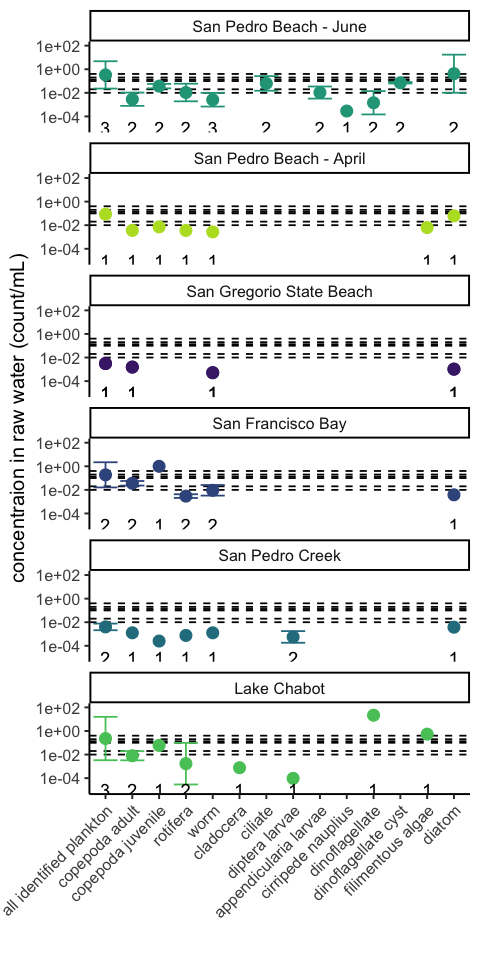

In [28]:
options(repr.plot.width =4, repr.plot.height = 8) #change the size of the plot
theme_set(theme_classic(base_size=12))# set font size

d1=1/(0.25*10)
d2=1/(0.5*10)
d3=1/(0.75*10)
d4=1/10
d5=1/((250/50)*10)
d6=1/((500/50)*10)

value<-c(d1,d2,d3,d4,d5,d6)
dilution<- c("25", "50", "75","100","500", "1000")

b<-as.data.frame(cbind(dilution, value))


a<-df_group
a<-a[a$percent_raw == 100,]
a<-a[a$org=="M",]#remove duplicates
not_count_data<-c("Solids", 'collection temperature C','salinity','pH','turbidity', 'cell count - DAPI')
a=a[!(a$meta_description  %in% not_count_data),]
g<- ggplot(a, aes(x=meta_description, color=water))+
 geom_hline(yintercept=c(d1,d2,d3,d4,d5,d6), linetype='dashed')+
    geom_point( aes(y=meta_conc_value), size=3)+
    geom_errorbar(aes(x=meta_description, ymin=meta_conc_value/meta_std, ymax=meta_conc_value*meta_std))+
    xlab("")+
    ylab("concentraion in raw water (count/mL)")+
    scale_color_manual(values=c(cG,cC,cB,cE,cD,cF))+
    guides(color=guide_legend(""))+
    scale_y_log10(limits=c(0.00001,100))+
    facet_wrap(~water, ncol=1)+
    geom_text(data = a, aes(label = meta_reps, y=0.00001), color='black')+
    theme(legend.position= "none", axis.text.x = element_text(angle = 45, hjust=1) )

g

ggsave(paste0(path_f,"Figure_4.jpg"),  units='mm',device= 'jpg',width=half.col_w/1.5, height=max_h)

# ragg::agg_tiff(paste0(path_f,"Figure_4.tiff"),  width=half.col_w/1.5, height=max_h, units='mm', res = 1000)
# g
# dev.off()
# g


In [29]:
d6

[1] 0.01

In [30]:
a[a$meta_conc_value > d1, c("meta_description","water","meta_conc_value")]

meta_description,water,meta_conc_value
<fct>,<fct>,<dbl>
copepoda juvenile,San Francisco Bay,0.9927273
dinoflagellate,Lake Chabot,21.6000000
filimentous algae,Lake Chabot,0.5400000
diatom,San Pedro Beach - June,0.4189641


In [31]:
a[, c("meta_description","water","meta_conc_value")]

meta_description,water,meta_conc_value
<fct>,<fct>,<dbl>
all identified plankton,San Gregorio State Beach,3.103448e-03
copepoda adult,San Gregorio State Beach,1.551724e-03
diatom,San Gregorio State Beach,1.034483e-03
worm,San Gregorio State Beach,5.172414e-04
all identified plankton,San Gregorio State Beach,3.103448e-03
copepoda adult,San Gregorio State Beach,1.551724e-03
diatom,San Gregorio State Beach,1.034483e-03
worm,San Gregorio State Beach,5.172414e-04
all identified plankton,San Pedro Beach - April,8.530612e-02


### Figure 2 - Cell count DAPI & Solids

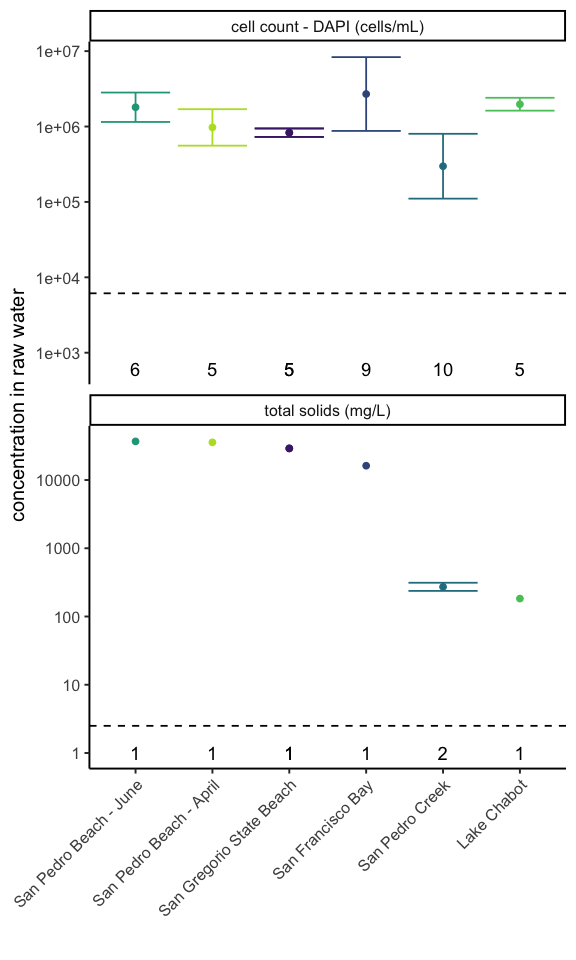

In [32]:
options(repr.plot.width =4.8, repr.plot.height = 8) #change the size of the plot
theme_set(theme_classic(base_size=12))# set font size

a<-df_group
a<-a[a$org=="M",]#remove duplicates
a<-a[a$percent_raw ==100,]
not_count_data<-c("Solids", "cell count - DAPI")
a=a[(a$meta_description  %in% not_count_data),]

a$height<-NA
a[a$meta_description == "Solids", "height"]<- 1
a[a$meta_description == "cell count - DAPI", "height"]<- DAPI_LOD/10

a$LOD<-NA
a[a$meta_description == "Solids", "LOD"]<- solids_LOD
a[a$meta_description == "cell count - DAPI", "LOD"]<- DAPI_LOD

a$description<-as.character(a$meta_description)
a[a$meta_description == "Solids", "description"]<- "total solids (mg/L)"
a[a$meta_description == "cell count - DAPI", "description"]<- "cell count - DAPI (cells/mL)"
g<- ggplot(a, aes(x=water, color=water))+
    geom_point( aes(y=meta_conc_value))+
    geom_errorbar(aes(x=water, ymin=meta_conc_value/meta_std, ymax=meta_conc_value*meta_std))+
    xlab("")+
    ylab("concentration in raw water")+
    geom_hline(data=a,aes(yintercept=LOD), linetype='dashed')+
    scale_color_manual(values=c(cG,cC,cB,cE,cD,cF))+
    # scale_y_log10()+
    guides(color=guide_legend("none"))+
    scale_y_log10()+
    facet_wrap(~description, ncol=1, scales="free_y")+
    geom_text(data = a, aes(label = meta_reps, y=height), color='black')+
    theme(legend.position= "none", axis.text.x = element_text(angle = 45, hjust=1) )

g

ggsave(paste0(path_f,"Figure_2.jpg"),  units='mm',device= 'jpg',width=half.col_w/1.5, height=max_h/2)


# ragg::agg_tiff(paste0(path_f,"Figure_2.tiff"),  width=half.col_w/1.5, height=max_h/2, units='mm', res = 1000)
# g
# dev.off()
# g


In [33]:
fresh<-c("Lake Chabot", "San Pedro Creek")
sols<- a[((a$meta_description == "Solids") & (a$water %in% fresh)),]

format(min(sols$meta_conc_value), scientific=TRUE, digits=2)
format(max(sols$meta_conc_value), scientific=TRUE, digits=2)
format(mean(sols$meta_conc_value), scientific=TRUE, digits=2)
format(sd(sols$meta_conc_value), scientific=TRUE, digits=2)

sols<- a[((a$meta_description == "Solids") & (!(a$water %in% fresh))),]

format(min(sols$meta_conc_value), scientific=TRUE, digits=2)
format(max(sols$meta_conc_value), scientific=TRUE, digits=2)
format(mean(sols$meta_conc_value), scientific=TRUE, digits=2)
format(sd(sols$meta_conc_value), scientific=TRUE, digits=2)

[1] "1.8e+02"

[1] "2.7e+02"

[1] "2.3e+02"

[1] "6.3e+01"

[1] "1.6e+04"

[1] "3.7e+04"

[1] "2.9e+04"

[1] "8.2e+03"

In [34]:
sols<- a[((a$meta_description == "cell count - DAPI")),]

format(min(sols$meta_conc_value), scientific=TRUE, digits=2)
format(max(sols$meta_conc_value), scientific=TRUE, digits=2)
format(mean(sols$meta_conc_value), scientific=TRUE, digits=2)
format(sd(sols$meta_conc_value), scientific=TRUE, digits=2)

[1] "3e+05"

[1] "2.7e+06"

[1] "1.3e+06"

[1] "8.4e+05"

### Table S8 -Temperature, Salinity, etc summary

In [35]:
a<-field_w[,c("water","filtered", "collection_temperature_C", "salinity","pH","turbidity")]
a[a$turbidity <1, "turbidity"]<- NA
a$turbidity<- as.character(a$turbidity)
a[is.na(a$turbidity), "turbidity"]<- "<1"

a

stargazer(a,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S8.doc"))

water,filtered,collection_temperature_C,salinity,pH,turbidity
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
San Gregorio State Beach,R,11.3,24.3,7.86,5.4
San Gregorio State Beach,F,NA,NA,7.93,<1
San Pedro Beach - April,R,11.2,32.1,7.78,8.1
San Pedro Beach - April,F,NA,NA,7.84,<1
San Pedro Creek,R,12.9,0.2,8.02,5.6
San Pedro Creek,F,NA,NA,8.03,<1
San Francisco Bay,R,17.7,15.0,7.99,14.8
San Francisco Bay,F,NA,NA,8.03,<1
Lake Chabot,R,20.6,0.2,8.05,6.1



<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">water</td><td>filtered</td><td>collection_temperature_C</td><td>salinity</td><td>pH</td><td>turbidity</td></tr>
<tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">San Gregorio State Beach</td><td>R</td><td>11.3000</td><td>24.3000</td><td>7.8600</td><td>5.4</td></tr>
<tr><td style="text-align:left">San Gregorio State Beach</td><td>F</td><td></td><td></td><td>7.9300</td><td>< 1</td></tr>
<tr><td style="text-align:left">San Pedro Beach - April</td><td>R</td><td>11.2000</td><td>32.1000</td><td>7.7800</td><td>8.1</td></tr>
<tr><td style="text-align:left">San Pedro Beach - April</td><td>F</td><td></td><td></td><td>7.8400</td><td>< 1</td></tr>
<tr><td style="text-align:left">San Pedro Creek</td><td>R</td><td>12.9000</td><td>0.2000</td><td>8.0200</td><td>5.6</td></tr>
<tr><td style="text-align:left">San Pedro Cr

### Figure S1 - Incubation time experiment

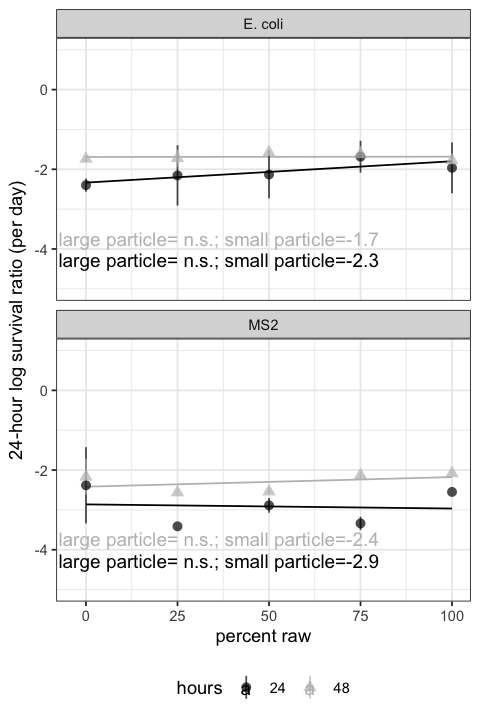

In [36]:
options(repr.plot.width =4, repr.plot.height = 6) #change the size of the plot

a<-df_group
a<-a[a$water =="San Gregorio State Beach",]
a<-a[a$meta_description == "salinity",] #no repeats
a$bdl<-factor(a$bdl)
a[a$org=="M","org"]<- "MS2"
a[a$org=="K","org"]<- "E. coli"
a$hours<- NA
a[a$day ==1, "hours"]<- 24
a[a$day ==2, "hours"]<- 48
a$hours<- as.factor(a$hours)

g<-ggplot(a, aes(x=percent_raw,color=hours, shape=hours))+
    geom_line(aes(y=fit), show.legend=FALSE)+
    geom_pointrange(aes(y=apparent_rate_of_change_per_day,ymin= apparent_rate_of_change_per_day -std_apparent_rate_of_change_per_day, ymax= apparent_rate_of_change_per_day +std_apparent_rate_of_change_per_day ), size=0.5, alpha=0.7, stroke=1.2)+
    ylab("24-hour log survival ratio (per day)")+
    xlab("percent raw")+
    scale_color_manual(values=c('black','gray'))+
    facet_wrap(~org, nrow=2)+
    theme_bw()+
    ylim(-5,1)+
    theme(legend.position= "bottom", legend.box='vertical',legend.spacing.y = unit(0.01, 'cm'))

dfl<-unique(a[,c("g","p","k","pk","hours","water","org","temperature")])
dfl$bdl<-"quantifiable"
dfl[dfl$p >=0.05,"g"]<- NA
dfl[dfl$pk >=0.05,"k"]<- NA
dfl$g<-sprintf("%1.2g",dfl$g)
dfl$k<-sprintf("%1.2g",dfl$k)
dfl[dfl$g=="NA","g"]<-"n.s."
dfl[dfl$k=="NA","k"]<-"n.s."
dfl<- dfl%>% 
mutate(Label=paste("large particle= ",g, "; small particle=", k,sep=""))

g + geom_text_repel(data=dfl,aes(x=-3,y=-4,label=Label),size=4, direction="y", segment.color = "transparent",seed=11, alpha=1,   box.padding=0.1)

ggsave(paste0(path_f,"Figure_S1.jpg"),  units='mm',device= 'jpg',width=half.col_w/1.5, height=max_h/1.5)


#### Table S2 - Multiple Regression

In [37]:
base<-a
base<-base[base$org=="MS2",]
base<-base[base$bdl =="quantifiable",]

base$fday<- 0
base[base$hours =="48", "fday"]<-1

reg=lm(apparent_rate_of_change_per_day~percent_raw +day + percent_raw:day, data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S2.doc"))


Call:
lm(formula = apparent_rate_of_change_per_day ~ percent_raw + 
    day + percent_raw:day, data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52456 -0.23352  0.06042  0.21322  0.47928 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     -3.305728   0.714724  -4.625   0.0036 **
percent_raw     -0.004490   0.011671  -0.385   0.7137   
day              0.444010   0.452031   0.982   0.3639   
percent_raw:day  0.003451   0.007382   0.468   0.6566   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4126 on 6 degrees of freedom
Multiple R-squared:  0.493,	Adjusted R-squared:  0.2395 
F-statistic: 1.945 on 3 and 6 DF,  p-value: 0.2237



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-3.3057</td><td>0.7147</td><td>-4.6252</td><td>0.0036</td></tr>
<tr><td style="text-align:left">percent_raw</td><td>-0.0045</td><td>0.0117</td><td>-0.3847</td><td>0.7137</td></tr>
<tr><td style="text-align:left">day</td><td>0.4440</td><td>0.4520</td><td>0.9823</td><td>0.3639</td></tr>
<tr><td style="text-align:left">percent_raw:day</td><td>0.0035</td><td>0.0074</td><td>0.4675</td><td>0.6566</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


#### Table S3 - Multiple Regression

In [38]:
base<-a
base<-base[base$org=="E. coli",]
base<-base[base$bdl =="quantifiable",]

base$fday<- 0
base[base$hours =="48", "fday"]<-1

reg=lm(apparent_rate_of_change_per_day~percent_raw +day + percent_raw:day, data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S3.doc"))



Call:
lm(formula = apparent_rate_of_change_per_day ~ percent_raw + 
    day + percent_raw:day, data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.16515 -0.06503 -0.03908  0.05846  0.24852 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -2.977234   0.252185 -11.806 2.23e-05 ***
percent_raw      0.010644   0.004118   2.585  0.04150 *  
day              0.643179   0.159496   4.033  0.00686 ** 
percent_raw:day -0.005285   0.002605  -2.029  0.08879 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1456 on 6 degrees of freedom
Multiple R-squared:  0.809,	Adjusted R-squared:  0.7134 
F-statistic: 8.469 on 3 and 6 DF,  p-value: 0.01412



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-2.9772</td><td>0.2522</td><td>-11.8058</td><td>0.00002</td></tr>
<tr><td style="text-align:left">percent_raw</td><td>0.0106</td><td>0.0041</td><td>2.5848</td><td>0.0415</td></tr>
<tr><td style="text-align:left">day</td><td>0.6432</td><td>0.1595</td><td>4.0326</td><td>0.0069</td></tr>
<tr><td style="text-align:left">percent_raw:day</td><td>-0.0053</td><td>0.0026</td><td>-2.0290</td><td>0.0888</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


### Figure S2 - Dilution only experiment

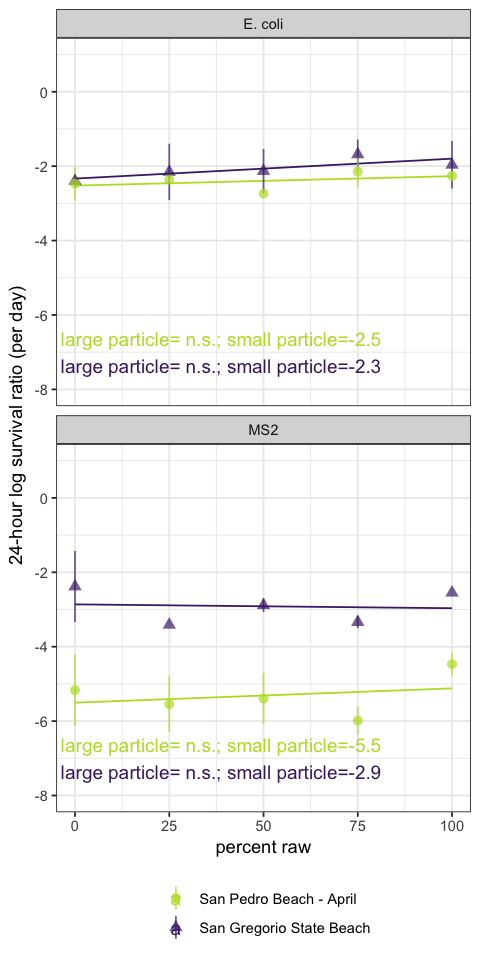

In [39]:
options(repr.plot.width =4, repr.plot.height = 8) #change the size of the plot

a<-df_group
a$bdl<-factor(a$bdl)
a<-a[a$day==1,]
exp1<-c("San Gregorio State Beach", "San Pedro Beach - April")
a<-a[a$water %in% exp1,]
a<-a[a$meta_description == "salinity",] #no repeats
a[a$org=="M","org"]<- "MS2"
a[a$org=="K","org"]<- "E. coli"
a$meta_conc_value<- as.numeric(a$meta_conc_value)
a$salinity<-a$meta_conc_value

g<-ggplot(a, aes(x=percent_raw,color=water, shape=water))+
    geom_line(aes(y=fit), show.legend=FALSE)+
    geom_pointrange(aes(y=apparent_rate_of_change_per_day,ymin= apparent_rate_of_change_per_day -std_apparent_rate_of_change_per_day, ymax= apparent_rate_of_change_per_day +std_apparent_rate_of_change_per_day ), size=0.5, alpha=0.7, stroke=1.2)+
    scale_color_manual(values=c(cC,cB))+
    ylab("24-hour log survival ratio (per day)")+
    xlab("percent raw")+
    guides(shape=guide_legend("",nrow=2,byrow=TRUE),color=guide_legend("",nrow=2,byrow=TRUE))+
    facet_wrap(~org,nrow=6 )+
    theme_bw()+
    ylim(-8,1)+
    theme(legend.position= "bottom", legend.box='vertical',legend.spacing.y = unit(0.01, 'cm'))

dfl<-unique(a[,c("g","p","k","pk","day","water","org","temperature")])
dfl$bdl<-"quantifiable"
dfl[dfl$p >=0.05,"g"]<- NA
dfl[dfl$pk >=0.05,"k"]<- NA
dfl$g<-sprintf("%1.2g",dfl$g)
dfl$k<-sprintf("%1.2g",dfl$k)
dfl[dfl$g=="NA","g"]<-"n.s."
dfl[dfl$k=="NA","k"]<-"n.s."
dfl<- dfl%>% 
mutate(Label=paste("large particle= ",g, "; small particle=", k,sep=""))


g + geom_text_repel(data=dfl,aes(x=0,y=-7,label=Label),size=4, direction="y", segment.color = "transparent",seed=11, alpha=1, box.padding=0.2, max.overlaps = Inf)

ggsave(paste0(path_f,"Figure_S2.jpg"),  units='mm',device= 'jpg',width=half.col_w/1.5, height=max_h/1.5)

#### Table S5 - Multiple Regression

In [40]:
base<-a
base<-base[base$org=="MS2",]
base<-base[base$bdl =="quantifiable",]

base$C<-0 #san gregorio will be the basse condition
base[base$water == "San Pedro Beach - April","C"]<- 1

reg=lm(apparent_rate_of_change_per_day~percent_raw + C +C:percent_raw, data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S5.doc"))



Call:
lm(formula = apparent_rate_of_change_per_day ~ percent_raw + 
    C + C:percent_raw, data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.76823 -0.33357 -0.02733  0.39641  0.65159 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.861718   0.446270  -6.413 0.000679 ***
percent_raw   -0.001039   0.007288  -0.143 0.891315    
C             -2.642877   0.631121  -4.188 0.005765 ** 
percent_raw:C  0.004892   0.010306   0.475 0.651827    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5761 on 6 degrees of freedom
Multiple R-squared:  0.8791,	Adjusted R-squared:  0.8186 
F-statistic: 14.54 on 3 and 6 DF,  p-value: 0.003687



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-2.8617</td><td>0.4463</td><td>-6.4125</td><td>0.0007</td></tr>
<tr><td style="text-align:left">percent_raw</td><td>-0.0010</td><td>0.0073</td><td>-0.1425</td><td>0.8913</td></tr>
<tr><td style="text-align:left">C</td><td>-2.6429</td><td>0.6311</td><td>-4.1876</td><td>0.0058</td></tr>
<tr><td style="text-align:left">percent_raw:C</td><td>0.0049</td><td>0.0103</td><td>0.4746</td><td>0.6518</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


#### Table S4 - Multiple Regression

In [41]:
base<-a
base<-base[base$org=="E. coli",]
base<-base[base$bdl =="quantifiable",]

base$C<-0 #san gregorio will be the basse condition
base[base$water == "San Pedro Beach - April","C"]<- 1

reg=lm(apparent_rate_of_change_per_day~percent_raw + C +C:percent_raw, data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S4.doc"))


Call:
lm(formula = apparent_rate_of_change_per_day ~ percent_raw + 
    C + C:percent_raw, data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.34119 -0.06503  0.02637  0.08492  0.24852 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.334055   0.162050 -14.403 7.01e-06 ***
percent_raw    0.005360   0.002646   2.025   0.0892 .  
C             -0.188003   0.229173  -0.820   0.4434    
percent_raw:C -0.002825   0.003742  -0.755   0.4789    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2092 on 6 degrees of freedom
Multiple R-squared:  0.6514,	Adjusted R-squared:  0.4771 
F-statistic: 3.737 on 3 and 6 DF,  p-value: 0.07955



<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-2.3341</td><td>0.1620</td><td>-14.4033</td><td>0.00001</td></tr>
<tr><td style="text-align:left">percent_raw</td><td>0.0054</td><td>0.0026</td><td>2.0254</td><td>0.0892</td></tr>
<tr><td style="text-align:left">C</td><td>-0.1880</td><td>0.2292</td><td>-0.8204</td><td>0.4434</td></tr>
<tr><td style="text-align:left">percent_raw:C</td><td>-0.0028</td><td>0.0037</td><td>-0.7549</td><td>0.4789</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr></table>


## 6. Calculate g (concentrated)

In [42]:
# reset
df_group<- df_group_og

In [43]:
#determine k values (grouped only)


gobs<-data.frame(type=character(),
                 g=as.numeric(), 
                 k=as.numeric(), 
                 se=as.numeric(), 
                 p=as.numeric(),
                 pk=as.numeric(),
                 sek=as.numeric(),
                 n=as.numeric(), 
                 stringsAsFactors=FALSE)  
types<-unique(df_group$type)

percentages=data.frame(percent = sort(unique(df_group$percent_raw)))

pred_group= data.frame(type=character(),
                 fit=as.numeric(), 
                 upr=as.numeric(),
                 lwr=as.numeric(),
                 percent_raw=as.numeric(),
                 stringsAsFactors=FALSE)

for(i in 1:length(types)) {
    type_i=types[i]
    c_type<-df_group[df_group$type==type_i,]
    c_type<-c_type[c_type$meta_description == "salinity",] #no repeats
    c_type<- c_type[(c_type$mean_lnNN0 > c_type$lower_limit_log),]
    percent_i=data.frame(percent_raw = sort(unique(c_type$percent_raw)))
    e<-lm(apparent_rate_of_change_per_day~percent_raw,data=c_type)
    tidy_e<-tidy(e)
    n<-length(c_type$apparent_rate_of_change_per_day)
    g<-tidy_e[tidy_e$term=="percent_raw",]$estimate
    k<-tidy_e[tidy_e$term=="(Intercept)",]$estimate
    pk<-tidy_e[tidy_e$term=="(Intercept)",]$p.value
    sek<-tidy_e[tidy_e$term=="(Intercept)",]$std.error
    se<-tidy_e[tidy_e$term=="percent_raw",]$std.error
    p<-tidy_e[tidy_e$term=="percent_raw",]$p.value
    df_fin<-do.call(rbind, Map(data.frame, type=list(type_i),g=list(g),k=list(k),se=list(se),p=list(p),pk=list(pk),sek=list(sek), n=list(n)))
    gobs=rbind(gobs,df_fin)
    pred_y<-as.data.frame(predict(e, newdata=percent_i, interval = "confidence"))
    pred_y$percent_raw<-unlist(percent_i$percent_raw)
    pred_y$type<-type_i
    pred_group=rbind(pred_group,pred_y)
}


gobs$g_upr<-gobs$g+gobs$se
gobs$g_lwr<-gobs$g-gobs$se
gobs<-gobs%>%mutate(includes0 =  (g_upr>=0)  & (g_lwr <=0))
gobs<-gobs%>%mutate(not_signif =  (p>=0.05))

gobs$g_plot<-gobs$g
length(gobs$g)
length(gobs[gobs$not_signif==TRUE, "g"])#11/14 were ~0  but B and C didn't have concentrated values

df_group<-left_join(df_group, gobs[,c("type","g","p","k","pk")])
df_group<-left_join(df_group, pred_group)

types
gobs<- gobs %>% 
    separate(type, c('project',"water", "day","org","temperature"), "-") 
gobs<-gobs[order(as.character(gobs$project), as.character(gobs$org), as.character(gobs$water), as.character(gobs$day)),]

head(gobs)


gobs_all2<-gobs[(gobs$water %in% c("D", "E","F","G")) & (gobs$day ==1),]
gobs_all2

gobs_all<-rbind(gobs_all,gobs_all2)



[1] 14

[1] 12

Joining with `by = join_by(type)`
Joining with `by = join_by(percent_raw, type)`


[1] "grazing-B-1-K-15" "grazing-B-2-K-15" "grazing-B-1-M-15" "grazing-B-2-M-15"
 [5] "grazing-C-1-K-15" "grazing-C-1-M-15" "grazing-D-1-K-15" "grazing-D-1-M-15"
 [9] "grazing-E-1-K-15" "grazing-E-1-M-15" "grazing-F-1-K-15" "grazing-F-1-M-15"
[13] "grazing-G-1-K-15" "grazing-G-1-M-15"

,project,water,day,org,temperature,g,k,se,p,pk,sek,n,g_upr,g_lwr,includes0,not_signif,g_plot
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
1,grazing,B,1,K,15,5.359791e-03,-2.3340551,0.0023036571,0.10246086,0.0004805691,0.14106961,5,0.0076634480,0.0030561338,FALSE,TRUE,5.359791e-03
2,grazing,B,2,K,15,7.512741e-05,-1.6908760,0.0012152583,0.95459426,0.0001867102,0.07441907,5,0.0012903858,-0.0011401309,TRUE,TRUE,7.512741e-05
5,grazing,C,1,K,15,2.534543e-03,-2.5220584,0.0029493304,0.45332941,0.0007951743,0.18060887,5,0.0054838730,-0.0004147878,TRUE,TRUE,2.534543e-03
7,grazing,D,1,K,15,-1.725278e-03,-0.8879996,0.0006803419,0.05215372,0.0333597779,0.30504667,7,-0.0010449359,-0.0024056196,FALSE,TRUE,-1.725278e-03
9,grazing,E,1,K,15,-1.420950e-04,-1.0818985,0.0005952007,0.82078768,0.0074443285,0.24941172,7,0.0004531057,-0.0007372957,TRUE,TRUE,-1.420950e-04
11,grazing,F,1,K,15,-4.552219e-04,-0.3284569,0.0003415320,0.24007652,0.0757552848,0.14700697,7,-0.0001136900,-0.0007967539,FALSE,TRUE,-4.552219e-04


,project,water,day,org,temperature,g,k,se,p,pk,sek,n,g_upr,g_lwr,includes0,not_signif,g_plot
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
7,grazing,D,1,K,15,-0.0017252778,-0.8879996,0.0006803419,0.05215372,3.335978e-02,0.3050467,7,-0.0010449359,-0.0024056196,FALSE,TRUE,-0.0017252778
9,grazing,E,1,K,15,-0.0001420950,-1.0818985,0.0005952007,0.82078768,7.444329e-03,0.2494117,7,0.0004531057,-0.0007372957,TRUE,TRUE,-0.0001420950
11,grazing,F,1,K,15,-0.0004552219,-0.3284569,0.0003415320,0.24007652,7.575528e-02,0.1470070,7,-0.0001136900,-0.0007967539,FALSE,TRUE,-0.0004552219
13,grazing,G,1,K,15,0.0010396756,-3.2579079,0.0003766063,0.03980429,6.713795e-06,0.1679301,7,0.0014162818,0.0006630693,FALSE,FALSE,0.0010396756
8,grazing,D,1,M,15,0.0003365569,-0.4662229,0.0004543082,0.49210933,7.075717e-02,0.2036993,7,0.0007908651,-0.0001177513,TRUE,TRUE,0.0003365569
10,grazing,E,1,M,15,0.0013200257,-3.2296454,0.0010542775,0.26592310,7.502758e-04,0.4417824,7,0.0023743032,0.0002657482,FALSE,TRUE,0.0013200257
12,grazing,F,1,M,15,0.0011603018,-1.4553511,0.0004038473,0.03486721,3.980069e-04,0.1738296,7,0.0015641491,0.0007564545,FALSE,FALSE,0.0011603018
14,grazing,G,1,M,15,0.0020003607,-4.5121064,0.0008779917,0.07168706,8.622955e-05,0.3914996,7,0.0028783524,0.0011223690,FALSE,TRUE,0.0020003607


In [44]:
check<-gobs[,c("water","day","org","k","pk")]
check[check$pk <0.05,]
# check[check$pk >=0.05,]

check<-gobs[,c("water","day","org","g","p")]
# check[check$p >=0.05,]
check[check$p <0.05,]

,water,day,org,k,pk
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,B,1,K,-2.3340551,4.805691e-04
2,B,2,K,-1.6908760,1.867102e-04
5,C,1,K,-2.5220584,7.951743e-04
7,D,1,K,-0.8879996,3.335978e-02
9,E,1,K,-1.0818985,7.444329e-03
13,G,1,K,-3.2579079,6.713795e-06
3,B,1,M,-2.8617181,6.016648e-03
4,B,2,M,-2.4177081,1.068857e-03
6,C,1,M,-5.5045949,1.424898e-03


,water,day,org,g,p
,<chr>,<chr>,<chr>,<dbl>,<dbl>
13,G,1,K,0.001039676,0.03980429
12,F,1,M,0.001160302,0.03486721


In [45]:
gobs_og<-gobs 

gobs_og<-gobs_og %>% select(c("org", "water", "day","g", "se", "p","k","sek","pk"))
gobs_og[gobs_og$org=="M", "org"]<- "MS2"
gobs_og[gobs_og$org=="K", "org"]<- "E. coli"
gobs_og[gobs_og$water=="B","water"]<- "San Gregorio State Beach"
gobs_og[gobs_og$water=="C","water"]<- "San Pedro Beach - April"
gobs_og[gobs_og$water=="D","water"]<- "San Pedro Creek"
gobs_og[gobs_og$water=="E","water"]<- "San Francisco Bay"
gobs_og[gobs_og$water=="F","water"]<- "Lake Chabot"
gobs_og[gobs_og$water=="G","water"]<- "San Pedro Beach - June"

gobs_og[gobs_og$day=="1", "day"]<- "24"
gobs_og[gobs_og$day=="2", "day"]<- "48"
names(gobs_og)<-c("Microorganism", "Environmental water","Incubation time (h)", "g","Standard error of g", "p-value of g", "k","Standard error of k","p-value of k")
gobs_og

,Microorganism,Environmental water,Incubation time (h),g,Standard error of g,p-value of g,k,Standard error of k,p-value of k
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,E. coli,San Gregorio State Beach,24,5.359791e-03,0.0023036571,0.10246086,-2.3340551,0.14106961,4.805691e-04
2,E. coli,San Gregorio State Beach,48,7.512741e-05,0.0012152583,0.95459426,-1.6908760,0.07441907,1.867102e-04
5,E. coli,San Pedro Beach - April,24,2.534543e-03,0.0029493304,0.45332941,-2.5220584,0.18060887,7.951743e-04
7,E. coli,San Pedro Creek,24,-1.725278e-03,0.0006803419,0.05215372,-0.8879996,0.30504667,3.335978e-02
9,E. coli,San Francisco Bay,24,-1.420950e-04,0.0005952007,0.82078768,-1.0818985,0.24941172,7.444329e-03
11,E. coli,Lake Chabot,24,-4.552219e-04,0.0003415320,0.24007652,-0.3284569,0.14700697,7.575528e-02
13,E. coli,San Pedro Beach - June,24,1.039676e-03,0.0003766063,0.03980429,-3.2579079,0.16793008,6.713795e-06
3,MS2,San Gregorio State Beach,24,-1.038816e-03,0.0066877796,0.88642362,-2.8617181,0.40954119,6.016648e-03
4,MS2,San Gregorio State Beach,48,2.412323e-03,0.0031244466,0.49631139,-2.4177081,0.19133250,1.068857e-03


In [46]:
stargazer(gobs_og,type="html", summary=FALSE, rownames=FALSE, digits=5, out=paste0(path_f,"Table_S1.doc"))


<table style="text-align:center"><tr><td colspan="9" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Microorganism</td><td>Environmental water</td><td>Incubation time (h)</td><td>g</td><td>Standard error of g</td><td>p-value of g</td><td>k</td><td>Standard error of k</td><td>p-value of k</td></tr>
<tr><td colspan="9" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">E. coli</td><td>San Gregorio State Beach</td><td>24</td><td>0.00536</td><td>0.00230</td><td>0.10246</td><td>-2.33406</td><td>0.14107</td><td>0.00048</td></tr>
<tr><td style="text-align:left">E. coli</td><td>San Gregorio State Beach</td><td>48</td><td>0.00008</td><td>0.00122</td><td>0.95459</td><td>-1.69088</td><td>0.07442</td><td>0.00019</td></tr>
<tr><td style="text-align:left">E. coli</td><td>San Pedro Beach - April</td><td>24</td><td>0.00253</td><td>0.00295</td><td>0.45333</td><td>-2.52206</td><td>0.18061</td><td>0.00080</td></tr>
<tr><td style="text-align:

## 7. Plotting

### Figure 1 - Dilution and concentration experiment

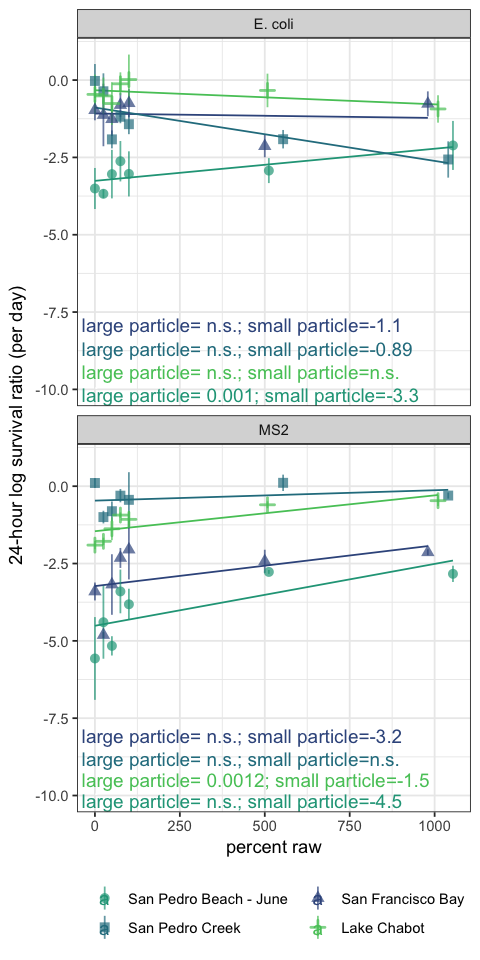

In [47]:
options(repr.plot.width =4, repr.plot.height = 8) #change the size of the plot

a<-df_group
a$bdl<-factor(a$bdl)
a<-a[a$day==1,]
exp1<-c("San Gregorio State Beach", "San Pedro Beach - April")
a<-a[!(a$water %in% exp1),]
a[a$org=="M","org"]<- "MS2"
a[a$org=="K","org"]<- "E. coli"
a$meta_conc_value<- as.numeric(a$meta_conc_value)
a$salinity<-a$meta_conc_value

a<-a[a$meta_description == "salinity",] #no repeats

g<-ggplot(a, aes(x=percent_raw,color=water, shape=water))+
    geom_line(aes(y=fit), show.legend=FALSE)+
    geom_pointrange(aes(y=apparent_rate_of_change_per_day,ymin= apparent_rate_of_change_per_day -std_apparent_rate_of_change_per_day, ymax= apparent_rate_of_change_per_day +std_apparent_rate_of_change_per_day ), size=0.5, alpha=0.7, stroke=1.2)+
    scale_color_manual(values=c(cG,cE,cD,cF))+
    ylab("24-hour log survival ratio (per day)")+
    xlab("percent raw")+
    guides(shape=guide_legend("",nrow=2,byrow=TRUE), color=guide_legend("",nrow=2,byrow=TRUE))+
    facet_wrap(~org,nrow=6 )+
    theme_bw()+
    # ylim(-8,1)+
    theme(legend.position= "bottom", legend.box='vertical',legend.spacing.y = unit(0.01, 'cm'))

dfl<-unique(a[,c("g","p","k","pk","day","water","org","temperature")])
dfl$bdl<-"quantifiable"
dfl[dfl$p >=0.05,"g"]<- NA
dfl[dfl$pk >=0.05,"k"]<- NA
dfl$g<-sprintf("%1.2g",dfl$g)
dfl$k<-sprintf("%1.2g",dfl$k)
dfl[dfl$g=="NA","g"]<-"n.s."
dfl[dfl$k=="NA","k"]<-"n.s."
dfl<- dfl%>% 
mutate(Label=paste("large particle= ",g, "; small particle=", k,sep=""))


g + geom_text_repel(data=dfl,aes(x=0,y=-10,label=Label),size=4, direction="y", segment.color = "transparent",seed=11, alpha=1, box.padding=0.2, max.overlaps = Inf)

ggsave(paste0(path_f,"Figure_1.jpg"),  units='mm',device= 'jpg',width=half.col_w/1.5, height=max_h/1.5)

# ragg::agg_tiff(paste0(path_f,"Figure_1.tiff"),  width=half.col_w/1.5, height=max_h/2, units='mm', res = 1000)
# g
# dev.off()
# g

#### Table S7 - Multiple Regression

In [48]:
base<-a
base<-base[base$org=="MS2",]
base<-base[base$bdl =="quantifiable",]

base$E<-0 #Lake Chabot will be the basse condition
base[base$water == "San Francisco Bay","E"]<- 1
base$D<-0 #san pedro creek will be the basse condition
base[base$water == "San Pedro Creek","D"]<- 1
base$G<-0 #san pedro creek will be the basse condition
base[base$water == "San Pedro Beach - June","G"]<- 1

reg=lm(apparent_rate_of_change_per_day~percent_raw + E + D + G + percent_raw:E +percent_raw:D +percent_raw:G, data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S7.doc"))



Call:
lm(formula = apparent_rate_of_change_per_day ~ percent_raw + 
    E + D + G + percent_raw:E + percent_raw:D + percent_raw:G, 
    data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.61412 -0.35665  0.00665  0.40066  1.04941 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.4553511  0.3241941  -4.489 0.000224 ***
percent_raw    0.0011603  0.0007532   1.541 0.139103    
E             -1.7742943  0.4591003  -3.865 0.000965 ***
D              0.9891282  0.4586314   2.157 0.043379 *  
G             -3.0567553  0.4574704  -6.682 1.67e-06 ***
percent_raw:E  0.0001597  0.0010812   0.148 0.884040    
percent_raw:D -0.0008237  0.0010444  -0.789 0.439522    
percent_raw:G  0.0008401  0.0010446   0.804 0.430751    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6945 on 20 degrees of freedom
Multiple R-squared:  0.8669,	Adjusted R-squared:  0.8204 
F-statistic: 18.61 on 7 and 20 DF, 


<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-1.4554</td><td>0.3242</td><td>-4.4891</td><td>0.0002</td></tr>
<tr><td style="text-align:left">percent_raw</td><td>0.0012</td><td>0.0008</td><td>1.5405</td><td>0.1391</td></tr>
<tr><td style="text-align:left">E</td><td>-1.7743</td><td>0.4591</td><td>-3.8647</td><td>0.0010</td></tr>
<tr><td style="text-align:left">D</td><td>0.9891</td><td>0.4586</td><td>2.1567</td><td>0.0434</td></tr>
<tr><td style="text-align:left">G</td><td>-3.0568</td><td>0.4575</td><td>-6.6819</td><td>0.000002</td></tr>
<tr><td style="text-align:left">percent_raw:E</td><td>0.0002</td><td>0.0011</td><td>0.1477</td><td>0.8840</td></tr>
<tr><td style="text-align:left">percent_raw:D</t

#### Table S6 - Multiple Regression

In [49]:
base<-a
base<-base[base$org=="E. coli",]
base<-base[base$bdl =="quantifiable",]

base$E<-0 #Lake Chabot will be the basse condition
base[base$water == "San Francisco Bay","E"]<- 1
base$D<-0 #san pedro creek will be the basse condition
base[base$water == "San Pedro Creek","D"]<- 1
base$G<-0 #san pedro creek will be the basse condition
base[base$water == "San Pedro Beach - June","G"]<- 1

reg=lm(apparent_rate_of_change_per_day~percent_raw + E + D + G + percent_raw:E +percent_raw:D +percent_raw:G, data=base)

summary(reg )

out<-tidy(reg,)
out<- as.data.frame(out)
stargazer(out,type="html", summary=FALSE, rownames=FALSE, digits=4, out=paste0(path_f,"Table_S6.doc"))



Call:
lm(formula = apparent_rate_of_change_per_day ~ percent_raw + 
    E + D + G + percent_raw:E + percent_raw:D + percent_raw:G, 
    data = base)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.98259 -0.18134  0.00361  0.25331  0.86041 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.3284569  0.2263091  -1.451   0.1622    
percent_raw   -0.0004552  0.0005258  -0.866   0.3969    
E             -0.7534416  0.3204826  -2.351   0.0291 *  
D             -0.5595426  0.3201553  -1.748   0.0958 .  
G             -2.9294510  0.3193448  -9.173 1.32e-08 ***
percent_raw:E  0.0003131  0.0007548   0.415   0.6827    
percent_raw:D -0.0012701  0.0007291  -1.742   0.0969 .  
percent_raw:G  0.0014949  0.0007292   2.050   0.0537 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4848 on 20 degrees of freedom
Multiple R-squared:  0.8581,	Adjusted R-squared:  0.8084 
F-statistic: 17.28 on 7 and 20 DF, 


<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">term</td><td>estimate</td><td>std.error</td><td>statistic</td><td>p.value</td></tr>
<tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">(Intercept)</td><td>-0.3285</td><td>0.2263</td><td>-1.4514</td><td>0.1622</td></tr>
<tr><td style="text-align:left">percent_raw</td><td>-0.0005</td><td>0.0005</td><td>-0.8658</td><td>0.3969</td></tr>
<tr><td style="text-align:left">E</td><td>-0.7534</td><td>0.3205</td><td>-2.3510</td><td>0.0291</td></tr>
<tr><td style="text-align:left">D</td><td>-0.5595</td><td>0.3202</td><td>-1.7477</td><td>0.0958</td></tr>
<tr><td style="text-align:left">G</td><td>-2.9295</td><td>0.3193</td><td>-9.1733</td><td>0</td></tr>
<tr><td style="text-align:left">percent_raw:E</td><td>0.0003</td><td>0.0008</td><td>0.4149</td><td>0.6827</td></tr>
<tr><td style="text-align:left">percent_raw:D</td><

## 8. Figure 5 - PCA

In [50]:
gobs_all_c <- gobs_all
gobs_all[(gobs_all$p >=0.05), "g"] <- 0
gobs_all[(gobs_all$pk >=0.05), "k"] <- 0

g_sub<-gobs_all[, c("water", "org","k","g")]

g_sub[g_sub$water=="B","water"]<- "San Gregorio State Beach"
g_sub[g_sub$water=="C","water"]<- "San Pedro Beach - April"
g_sub[g_sub$water=="D","water"]<- "San Pedro Creek"
g_sub[g_sub$water=="E","water"]<- "San Francisco Bay"
g_sub[g_sub$water=="F","water"]<- "Lake Chabot"
g_sub[g_sub$water=="G","water"]<- "San Pedro Beach - June"


gsub_nonpart<- g_sub[,c("water","org","k")]
gsub_nonpart_wide<-gsub_nonpart %>% spread(org, k)
names(gsub_nonpart_wide)<- c("water","small particle - E. coli", "small particle - MS2")

gsub_part<- g_sub[,c("water","org","g")]
gsub_part_wide<-gsub_part %>% spread(org, g)
names(gsub_part_wide)<- c("water","large particle - E. coli", "large particle - MS2")

,water,all_identified_plankton,cell_count,collection_temperature,copepoda_juvenile,pH,salinity,total_solids,turbidity
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,San Gregorio State Beach,-1.0410925,-0.6801679,-0.8884035,-0.4562136,-0.8504201,0.4650841,0.5587470,-0.6001885
2,San Pedro Beach - April,-0.4025846,-0.5168567,-0.9149230,-0.4562136,-1.6063490,0.9921043,0.9523746,0.1364065
3,San Pedro Creek,-1.0410925,-1.2816968,-0.4640914,-0.4562136,0.6614378,-1.1632732,-1.1585700,-0.5456259
4,San Francisco Bay,0.3678211,1.4371139,0.8088450,2.0372589,0.3779645,-0.1632862,-0.2086281,1.9642533
5,Lake Chabot,0.6749706,0.6200883,1.5779108,-0.3055115,0.9449112,-1.1632732,-1.1638907,-0.4092194
6,San Pedro Beach - June,1.4419780,0.4215191,-0.1193378,-0.3631066,0.4724556,1.0326443,1.0199672,-0.5456259


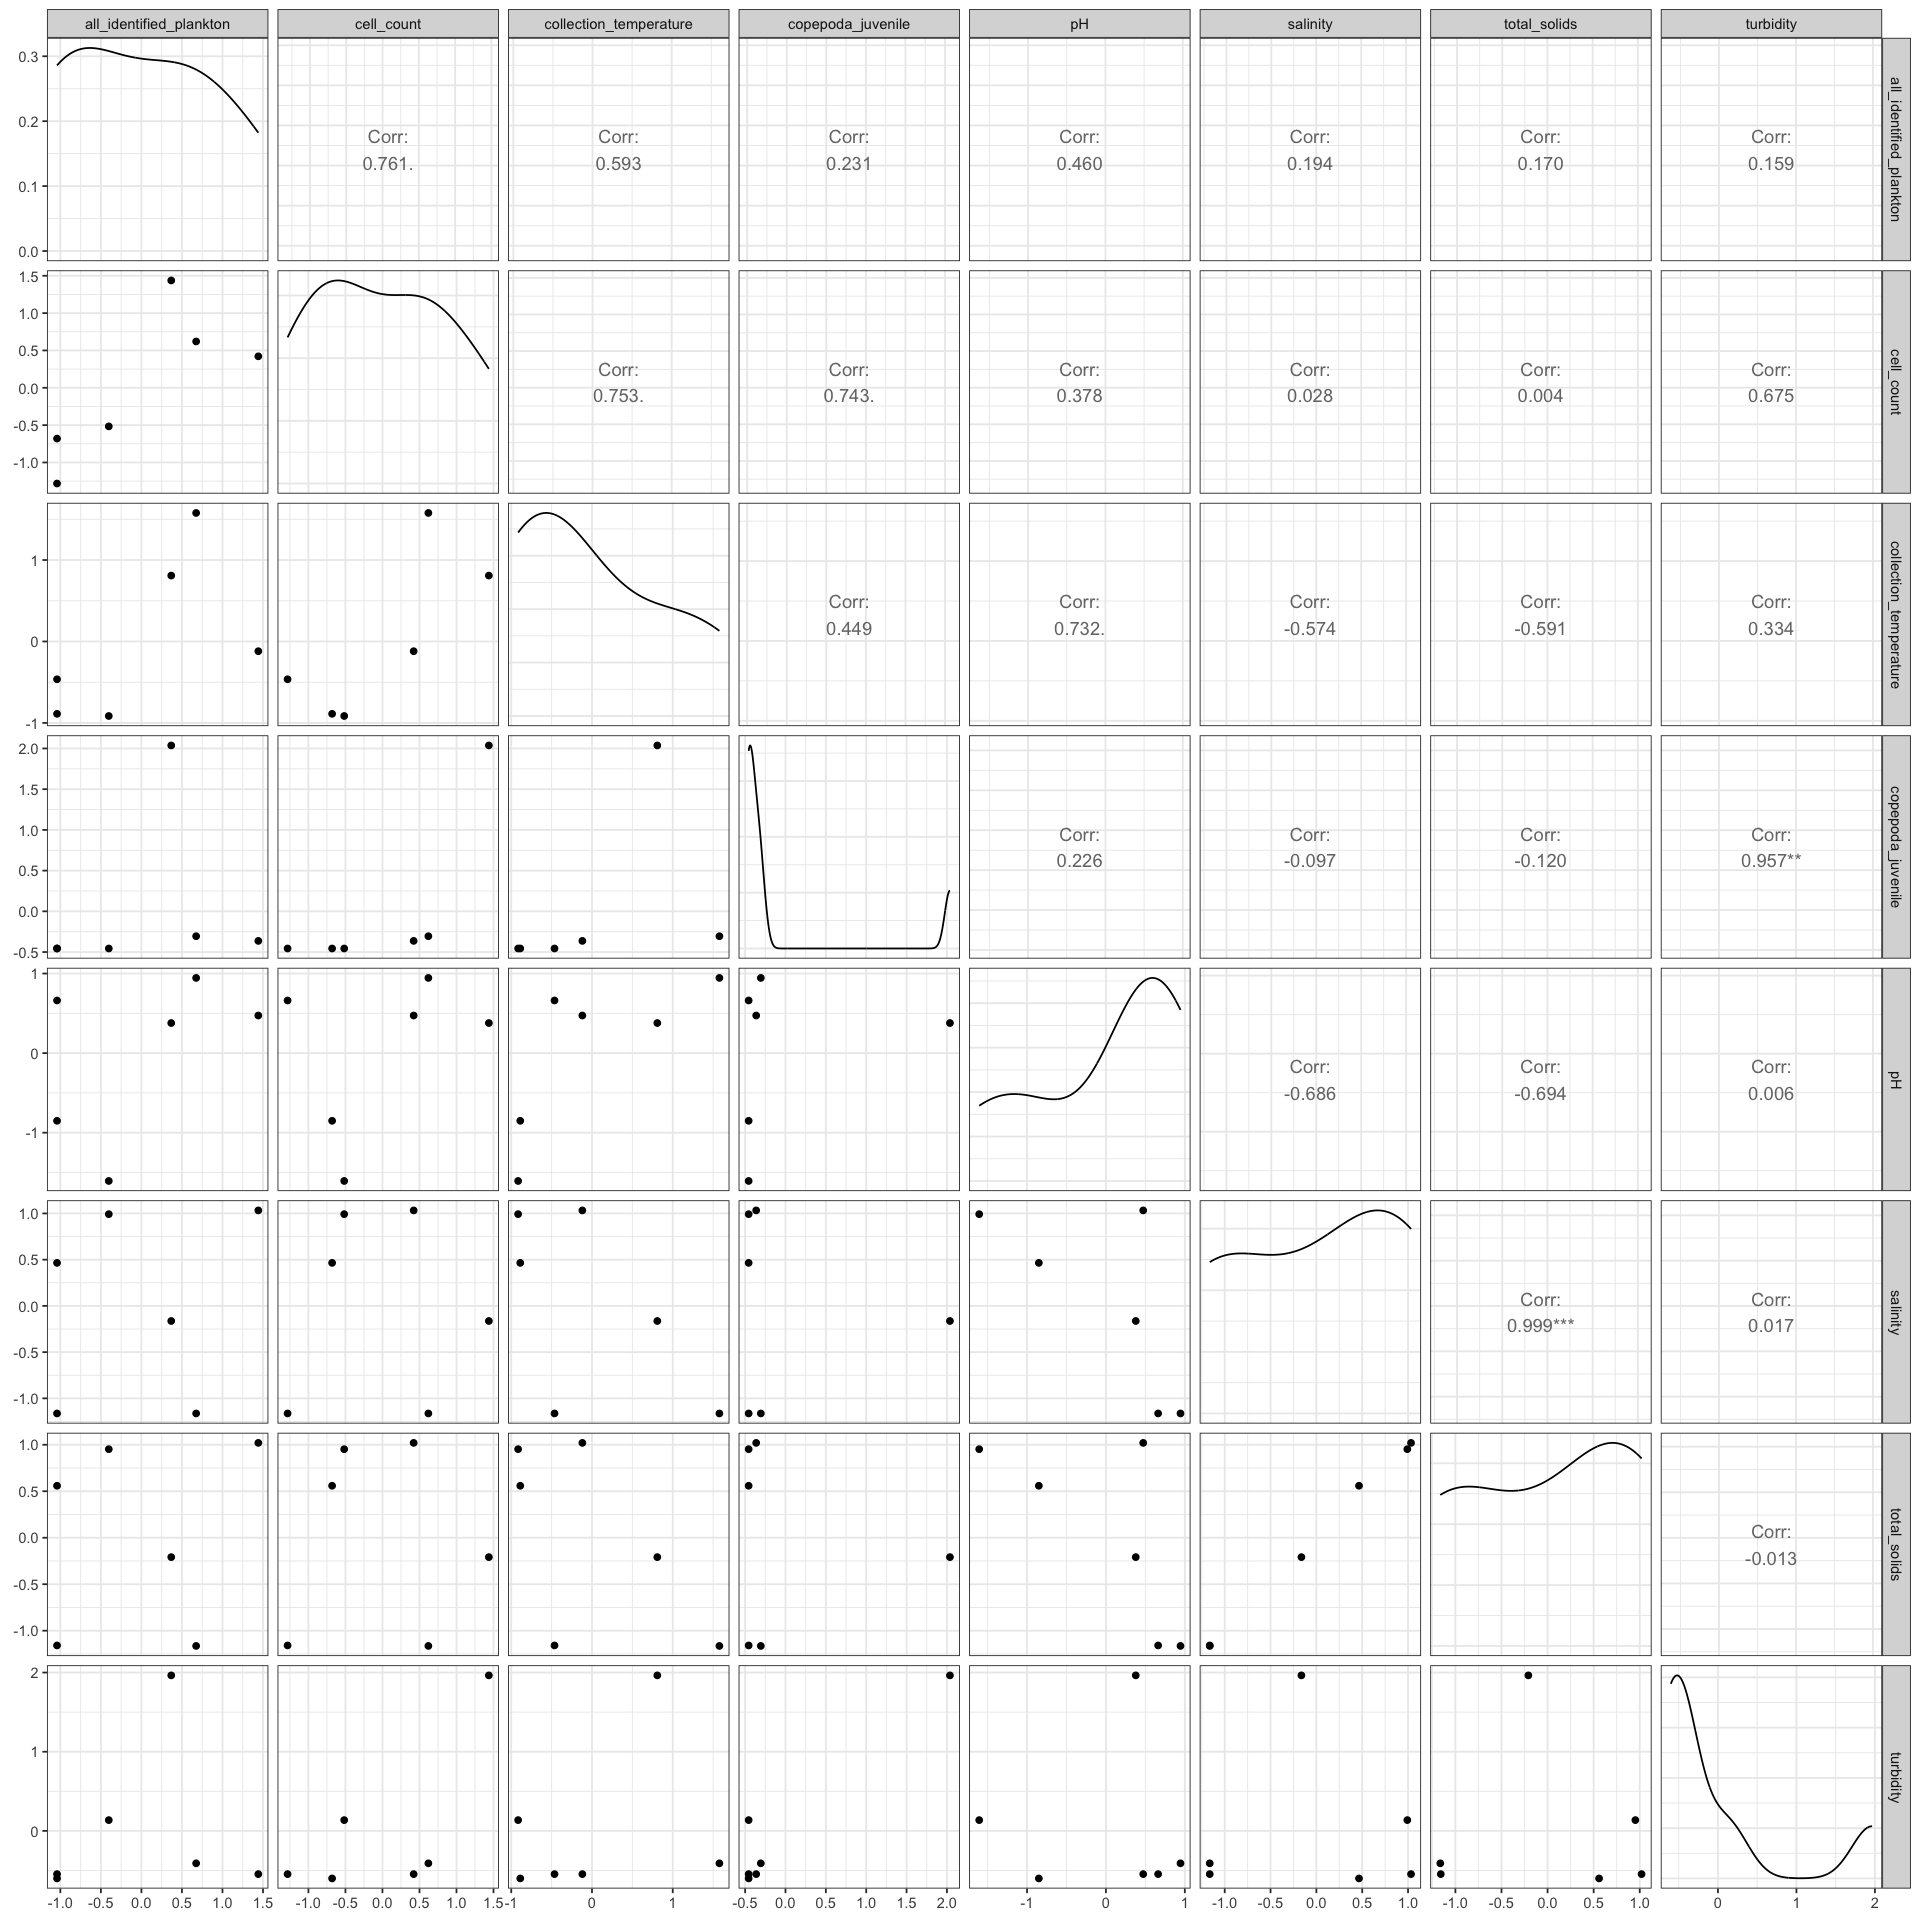

In [51]:
#http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/118-principal-component-analysis-in-r-prcomp-vs-princomp/
options(repr.plot.width =16, repr.plot.height = 16) #change the size of the plot
full_df_w<- full_df[,c("water", "meta_description", "meta_conc_value")]
full_df_w<-spread(full_df_w, meta_description,meta_conc_value )

full_df_w[full_df_w$water=="B","water"]<- "San Gregorio State Beach"
full_df_w[full_df_w$water=="C","water"]<- "San Pedro Beach - April"
full_df_w[full_df_w$water=="D","water"]<- "San Pedro Creek"
full_df_w[full_df_w$water=="E","water"]<- "San Francisco Bay"
full_df_w[full_df_w$water=="F","water"]<- "Lake Chabot"
full_df_w[full_df_w$water=="G","water"]<- "San Pedro Beach - June"

#if the concentration was less than D5, then it is unlikely that type was in more than 1 reactor
full_df_w[((full_df_w$all_identified_plankton < d5) | (is.na(full_df_w$all_identified_plankton))), "all_identified_plankton"]<- NA
full_df_w[((full_df_w$appendicularia_larvae < d5) | (is.na(full_df_w$appendicularia_larvae))), "appendicularia_larvae"]<- NA
full_df_w[((full_df_w$ciliate < d5) | (is.na(full_df_w$ciliate))), "ciliate"]<- NA
full_df_w[((full_df_w$cirripede_nauplius < d5) | (is.na(full_df_w$cirripede_nauplius))), "cirripede_nauplius"]<- NA
full_df_w[((full_df_w$cladocera < d5) | (is.na(full_df_w$cladocera))), "cladocera"]<- NA
full_df_w[((full_df_w$dinoflagellate < d5) | (is.na(full_df_w$dinoflagellate))), "dinoflagellate"]<- NA
full_df_w[((full_df_w$dinoflagellate_cyst < d5) | (is.na(full_df_w$dinoflagellate_cyst))), "dinoflagellate_cyst"]<- NA
full_df_w[((full_df_w$diptera_larvae < d5) | (is.na(full_df_w$diptera_larvae))), "diptera_larvae"]<- NA
full_df_w[((full_df_w$filimentous_algae < d5) | (is.na(full_df_w$filimentous_algae))), "filimentous_algae"]<- NA
full_df_w[((full_df_w$copepoda_adult < d5) | (is.na(full_df_w$copepoda_adult))), "copepoda_adult"]<- NA
full_df_w[((full_df_w$copepoda_juvenile < d5) | (is.na(full_df_w$copepoda_juvenile))), "copepoda_juvenile"]<- NA
full_df_w[((full_df_w$diatom < d5) | (is.na(full_df_w$diatom))), "diatom"]<- NA
full_df_w[((full_df_w$rotifera < d5) | (is.na(full_df_w$rotifera))), "rotifera"]<- NA
full_df_w[((full_df_w$worm < d5) | (is.na(full_df_w$rotifera))), "worm"]<- NA

check<-full_df_w %>% summarise(across(everything(), ~ sum(is.na(.))))
a<-colSums(check[,2:length(check)])
remove=names(a[a >3]) #remove these -- have more than half are 0
sub=names(a[(a >0) &(a <4)]) #substitute these with Lod

full_df_w<-full_df_w[,! (names(full_df_w) %in% remove)]
full_df_w[is.na(full_df_w$copepoda_juvenile), "copepoda_juvenile"]<- zoo_LOD
full_df_w[is.na(full_df_w$all_identified_plankton), "all_identified_plankton"]<- zoo_LOD
names(full_df_w)[names(full_df_w)=="collection_temperature_C"]<-"collection_temperature"
names(full_df_w)[names(full_df_w)=="cell_count_-_DAPI"]<-"cell_count"
names(full_df_w)[names(full_df_w)=="Solids"]<-"total_solids"

scale_df <- full_df_w
scale_df[,2:length(scale_df)]<- apply(scale_df[,2:length(scale_df)], 2, scale)
head(scale_df)

g=ggpairs(scale_df[,2:length(scale_df)], showStrips = TRUE)
g+theme(strip.background =element_blank(), strip.placement = "outside")+ theme_bw()

In [52]:
scale_df<- left_join(scale_df, gsub_part_wide)
scale_df<- left_join(scale_df, gsub_nonpart_wide)
scale_df["significant large particle decay coefficient - E. coli"]<-NA
scale_df[scale_df["large particle - E. coli"] != 0,"significant large particle decay coefficient - E. coli"]<- "Yes"
scale_df[scale_df["large particle - E. coli"] == 0,"significant large particle decay coefficient - E. coli"]<- "No"

scale_df["significant large particle decay coefficient - MS2"]<-NA
scale_df[scale_df["large particle - MS2"] != 0,"significant large particle decay coefficient - MS2"]<- "Yes"
scale_df[scale_df["large particle - MS2"] == 0,"significant large particle decay coefficient - MS2"]<- "No"


Joining with `by = join_by(water)`
Joining with `by = join_by(water)`


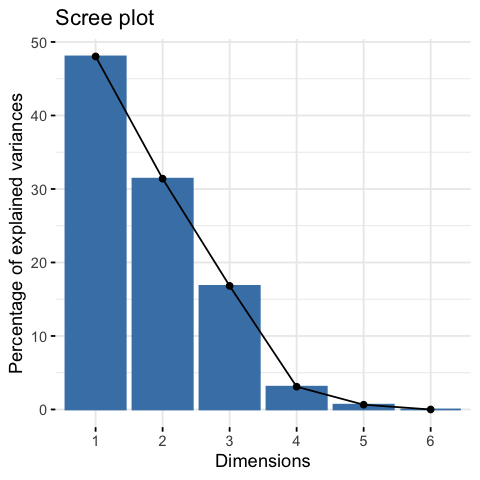

In [53]:
options(repr.plot.width =4, repr.plot.height = 4)
full_df_w<-data.frame(full_df_w)
rownames(full_df_w)<- full_df_w$water
full_df_w<-full_df_w[,2:length(full_df_w)]
pca<- prcomp(full_df_w, scale=TRUE)
fviz_eig(pca)


In [54]:
pca

Standard deviations (1, .., p=6):
[1] 1.960270e+00 1.584988e+00 1.159859e+00 4.978643e-01 2.280606e-01
[6] 2.503063e-16

Rotation (n x k) = (8 x 6):
                               PC1         PC2        PC3         PC4
all_identified_plankton -0.2811571  0.26629245 -0.6095483  0.08450702
cell_count              -0.4115528  0.34808988 -0.1235331 -0.24247631
collection_temperature  -0.4753217 -0.07425289 -0.1772363 -0.54852635
copepoda_juvenile       -0.3558004  0.30364650  0.4335215  0.31834024
pH                      -0.3900129 -0.27884366 -0.2630602  0.71146546
salinity                 0.2797179  0.50729066 -0.1916542  0.11154349
total_solids             0.2912424  0.49574044 -0.1929872  0.11034062
turbidity               -0.2896136  0.35965384  0.5006603  0.03228038
                                PC5         PC6
all_identified_plankton  0.56309978  0.18938394
cell_count              -0.43076083 -0.60673854
collection_temperature  -0.14783391  0.40839298
copepoda_juvenile       -0.27

In [55]:
options(repr.plot.width =10, repr.plot.height = 8)
ecoli<- fviz_pca_biplot(pca, axes=c(1,2), repel = TRUE,
                col.var = "grey", # Variables color
                col.ind =as.numeric(scale_df[['small particle - E. coli']]),
                addElipses=FALSE, invisible= "quali", 
                gradient.cols = c("#482991",  "#D11292", "#F8A97A"), title=""
                )+
        geom_point(aes(color= as.numeric(scale_df[['small particle - E. coli']]),shape= factor(scale_df[['significant large particle decay coefficient - E. coli']])), size=4)+
        labs(color="small particle\ndecay coefficient", shape= "large particle\ndecay coefficient significantly\ndifferent from 0?")

In [56]:
options(repr.plot.width =10, repr.plot.height = 8)
MS2<- fviz_pca_biplot(pca, axes=c(1,2), repel = TRUE,
                col.var = "grey", # Variables color
                col.ind =as.numeric(scale_df[['small particle - MS2']]),
                addElipses=FALSE, invisible= "quali", 
                gradient.cols = c("#482991",  "#D11292", "#F8A97A"), title=""
                )+
        geom_point(aes(color= as.numeric(scale_df[['small particle - MS2']]),shape= factor(scale_df[['significant large particle decay coefficient - MS2']])), size= 4)+
        labs(color="small particle\ndecay coefficient", shape= "large particle\ndecay coefficient significantly\ndifferent from 0?")

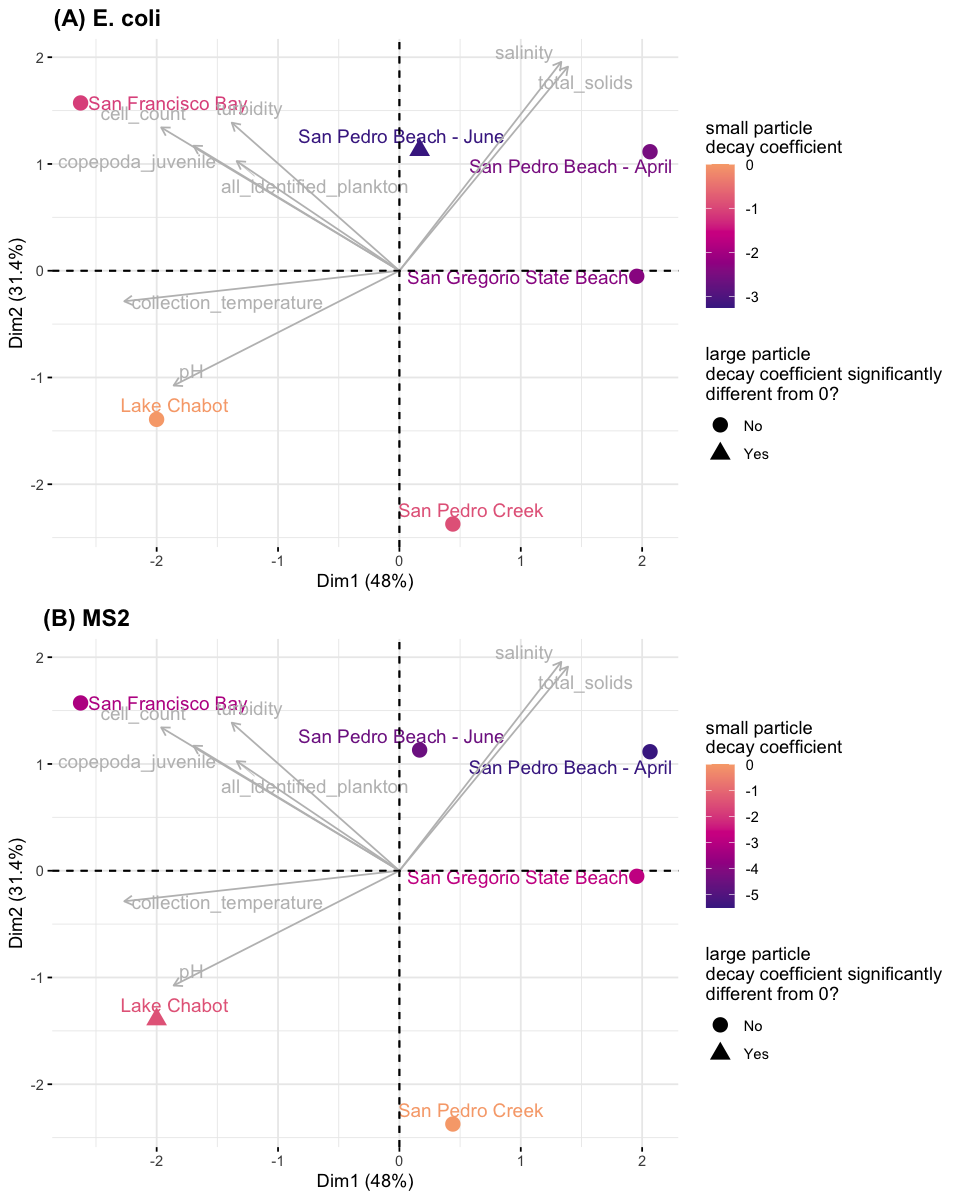

In [57]:
options(repr.plot.width =8, repr.plot.height =10)
# Arrange plots using ggarrange

g <- ggarrange(ecoli,  MS2, ncol= 1, labels = c("(A) E. coli", "(B) MS2"),
               common.legend=FALSE, legend='right')
g

ggsave(paste0(path_f,"Figure_5.jpg"),  units='mm',device= 'jpg',width=max_w/1.1, height=max_h/1.2)

# ragg::agg_tiff(paste0(path_f,"Figure_5.tiff"),  width=half.col_w/1.5, height=max_h/2, units='mm', res = 1000)
# g
# dev.off()
# g